In [15]:
# ============================================================================
# COMPREHENSIVE NETWORK ANALYSIS SETUP CELL
# This cell prepares all data structures needed for network analysis
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from collections import Counter, defaultdict
import re
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("COMPREHENSIVE NETWORK ANALYSIS SETUP")
print("="*80)

# ============================================================================
# STEP 1: LOAD AND CLEAN CSV DATA
# ============================================================================
print("\n[STEP 1/8] Loading CSV and removing duplicates...")

# Load the dataset
letters = pd.read_csv("swami_vivekananda_letters_complete.csv")
print(f"  Initial rows: {len(letters)}")

# Remove duplicates by full_url
letters = letters.drop_duplicates(subset=['full_url'], keep='first')
print(f"  After removing URL duplicates: {len(letters)}")

# Remove rows with no URL
letters = letters[letters['full_url'].notna() & (letters['full_url'] != '')]
print(f"  After removing rows with no URL: {len(letters)}")

# ============================================================================
# STEP 2: CLEAN AUDIENCE NAMES (FUZZY MATCHING)
# ============================================================================
print("\n[STEP 2/8] Cleaning audience names...")

# Strip whitespace from Audience column
letters['Audience'] = letters['Audience'].astype(str).str.strip()

# Define name corrections based on common issues
audience_mapping = {
    # Spelling variations
    'Chakravarti, Sharat Chandra': 'Chakravarty, Sharat Chandra',
    'Chakravarty, Sharat': 'Chakravarty, Sharat Chandra',

    # Trailing/leading whitespace issues
    'Perumal, Alasinga ': 'Perumal, Alasinga',
    ' Perumal, Alasinga': 'Perumal, Alasinga',

    # Common misspellings
    'Legget, Francis H': 'Leggett, Francis H',
    'Leggett, Francis H.': 'Leggett, Francis H',

    'Ghosal, Sarala': 'Ghoshal, Sarala',
    'Ghoshal, Sarla': 'Ghoshal, Sarala',

    'Sha, Lala Badri': 'Sah, Lala Badri',
    'Shah, Lala Badri': 'Sah, Lala Badri',

    # Other variations
    'Hale, Mrs. G. W.': 'Hale, G. W. Mrs.',
    'Hale, Mrs G. W.': 'Hale, G. W. Mrs.',

    'MacLeod, Miss Josephine': 'MacLeod, Josephine',

    'Bull, Miss Sarah': 'Bull, Sarah',

    'Sturdy, E. T.': 'Sturdy, E.T.',
    'Sturdy, E.T': 'Sturdy, E.T.',
}

# Apply corrections
letters['Audience_clean'] = letters['Audience'].replace(audience_mapping)

print(f"  Applied {len(audience_mapping)} name corrections")
print(f"  Unique recipients after cleaning: {letters['Audience_clean'].nunique()}")

# ============================================================================
# STEP 3: PARSE AND VALIDATE DATES
# ============================================================================
print("\n[STEP 3/8] Parsing and validating dates...")

# Parse dates - extract year as primary component
def parse_date_year(date_str):
    """Extract year from date string, handling various formats"""
    if pd.isna(date_str) or date_str == '':
        return None

    date_str = str(date_str).strip()

    # Try to parse yyyy/mm/dd or yyyy-mm-dd
    for sep in ['/', '-']:
        if sep in date_str:
            parts = date_str.split(sep)
            if len(parts) >= 1:
                try:
                    year = int(parts[0])
                    return year
                except:
                    pass

    # Try to extract 4-digit year from anywhere in string
    year_match = re.search(r'(18|19|20)\d{2}', date_str)
    if year_match:
        return int(year_match.group())

    return None

letters['year'] = letters['Date'].apply(parse_date_year)

# Validate years are in expected range (1888-1902)
valid_years = letters['year'].notna() & (letters['year'] >= 1888) & (letters['year'] <= 1902)
print(f"  Dates with valid years (1888-1902): {valid_years.sum()}/{len(letters)}")

# Show year distribution
if letters['year'].notna().sum() > 0:
    year_counts = letters['year'].value_counts().sort_index()
    print(f"  Year range: {letters['year'].min():.0f} to {letters['year'].max():.0f}")

# ============================================================================
# STEP 4: ASSIGN TEMPORAL PERIODS
# ============================================================================
print("\n[STEP 4/8] Assigning temporal periods...")

def assign_period(year):
    """Assign period based on Swamiji's life phases"""
    if pd.isna(year):
        return 'Unknown'

    if 1888 <= year < 1893:
        return 'Period1_India_1888-1893'
    elif 1893 <= year < 1897:
        return 'Period2_West_1893-1897'
    elif 1897 <= year < 1899:
        return 'Period3_India_1897-1899'
    elif 1899 <= year <= 1902:
        return 'Period4_West_Final_1899-1902'
    else:
        return 'Unknown'

letters['period'] = letters['year'].apply(assign_period)

period_counts = letters['period'].value_counts()
print("  Period distribution:")
for period in ['Period1_India_1888-1893', 'Period2_West_1893-1897',
               'Period3_India_1897-1899', 'Period4_West_Final_1899-1902', 'Unknown']:
    if period in period_counts:
        print(f"    {period}: {period_counts[period]}")

# Create all_letters dataframe
all_letters = letters.copy()
print(f"\n  ✓ Created all_letters dataframe with {len(all_letters)} rows")

# ============================================================================
# STEP 5: DEFINE FOCUS CORRESPONDENTS
# ============================================================================
print("\n[STEP 5/8] Defining focus correspondents...")

# Core focus correspondents (top recipients based on letter counts)
focus_correspondents = [
    'Bull, Sarah',
    'MacLeod, Josephine',
    'Hale, G. W. Mrs.',
    'Hale, Mary',
    'Hale, Sisters',
    'Christine, Sister',
    'Nivedita, Sister',
    'Sturdy, E.T.',
    'Perumal, Alasinga',
    'Brahmananda, Swami',
    'Desai, Viaharidas Haridas',
    'Halboister, Marie',
    'Leggett, Francis Mrs.',
    'McKindley, Isabelle',
    'Maharaja of Khetri (Singh, Ajit)',
]

# Extended focus correspondents (adds a few more key people)
extended_focus_correspondents = focus_correspondents + [
    'Goodwin, J.J.',
    'Leggett, Francis H',
]

print(f"  Core focus correspondents: {len(focus_correspondents)}")
print(f"  Extended focus correspondents: {len(extended_focus_correspondents)}")

# Filter letters to focus correspondents
focus_letters = all_letters[all_letters['Audience_clean'].isin(extended_focus_correspondents)].copy()
print(f"  Letters to focus correspondents: {len(focus_letters)}")

# ============================================================================
# STEP 6: LOAD SPACY NER MODEL
# ============================================================================
print("\n[STEP 6/8] Loading spaCy NER model...")

try:
    import spacy
    try:
        nlp = spacy.load('en_core_web_sm')
        print("  ✓ Loaded en_core_web_sm")
    except:
        print("  Downloading en_core_web_sm...")
        import subprocess
        subprocess.run(['python', '-m', 'spacy', 'download', 'en_core_web_sm'],
                      capture_output=True)
        nlp = spacy.load('en_core_web_sm')
        print("  ✓ Downloaded and loaded en_core_web_sm")
except Exception as e:
    print(f"  ⚠ Warning: Could not load spaCy: {e}")
    print("  You may need to install spaCy: !pip install spacy")
    nlp = None

# ============================================================================
# STEP 7: EXTRACT PERSON MENTIONS WITH NER
# ============================================================================
print("\n[STEP 7/8] Extracting person mentions from letters...")

if nlp is not None and len(focus_letters) > 0:
    all_mentions = []
    processed = 0

    for idx, row in focus_letters.iterrows():
        processed += 1
        if processed % 50 == 0:
            print(f"  Processing {processed}/{len(focus_letters)} letters...")

        if pd.notna(row['body_text']) and len(str(row['body_text'])) > 10:
            try:
                # Limit text length to avoid memory issues
                text = str(row['body_text'])[:50000]
                doc = nlp(text)

                for ent in doc.ents:
                    if ent.label_ == 'PERSON':
                        name = ent.text.strip()
                        # Filter out very short names or common titles
                        if len(name) > 2 and name.lower() not in ['sir', 'mr', 'mrs', 'miss', 'dr', 'swami', 'sister', 'the']:
                            all_mentions.append({
                                'name': name,
                                'letter_id': idx,
                                'letter_date': row['Date'],
                                'recipient': row['Audience_clean'],
                                'language': row.get('Language', 'Unknown'),
                                'period': row['period']
                            })
            except Exception as e:
                # Skip problematic letters
                continue

    mentions_df = pd.DataFrame(all_mentions)
    print(f"\n  ✓ Extracted {len(mentions_df)} person mentions")
    print(f"  ✓ Unique names found: {mentions_df['name'].nunique()}")
else:
    mentions_df = pd.DataFrame()
    print("  ⚠ Skipped NER extraction (spaCy not available or no letters)")

# ============================================================================
# STEP 8: CREATE NICKNAME MAPPING AND RESOLVE NAMES
# ============================================================================
print("\n[STEP 8/8] Creating nickname mapping and resolving names...")

# Comprehensive nickname mapping
nickname_mapping = {
    # Western correspondents - formal names
    'Bull': 'Bull, Sarah',
    'Ole Bull': 'Bull, Sarah',
    'Sarah Bull': 'Bull, Sarah',

    'Joe': 'MacLeod, Josephine',
    'JOE': 'MacLeod, Josephine',
    'Josephine': 'MacLeod, Josephine',
    'Jo': 'MacLeod, Josephine',

    'G. W. Hale': 'Hale, G. W. Mrs.',
    'Mrs. Hale': 'Hale, G. W. Mrs.',
    'Mrs Hale': 'Hale, G. W. Mrs.',

    'Mary': 'Hale, Mary',
    'Mary Hale': 'Hale, Mary',

    'Christine': 'Christine, Sister',
    'Sister Christine': 'Christine, Sister',

    # Sister Nivedita - IMPORTANT: Multiple mappings
    'Nivedita': 'Nivedita, Sister',
    'Sister Nivedita': 'Nivedita, Sister',
    'Margaret Noble': 'Nivedita, Sister',
    'Margaret E. Noble': 'Nivedita, Sister',
    'Noble': 'Nivedita, Sister',
    'MARGOT': 'Nivedita, Sister',
    'Miss Noble': 'Nivedita, Sister',

    'ALASINGA': 'Perumal, Alasinga',
    'Alasinga': 'Perumal, Alasinga',
    'Alasinga Perumal': 'Perumal, Alasinga',

    'E. T. Sturdy': 'Sturdy, E.T.',
    'Sturdy': 'Sturdy, E.T.',
    'E.T. Sturdy': 'Sturdy, E.T.',

    'Dewanji': 'Desai, Viaharidas Haridas',
    'Diwanji': 'Desai, Viaharidas Haridas',
    'Dewan': 'Desai, Viaharidas Haridas',
    'Diwan': 'Desai, Viaharidas Haridas',
    'Haridas Desai': 'Desai, Viaharidas Haridas',
    'Haridas': 'Desai, Viaharidas Haridas',
    'Biharidas': 'Desai, Viaharidas Haridas',

    'Khetri': 'Maharaja of Khetri (Singh, Ajit)',
    'Ajit Singh': 'Maharaja of Khetri (Singh, Ajit)',
    'Maharaja': 'Maharaja of Khetri (Singh, Ajit)',

    'Goodwin': 'Goodwin, J.J.',
    'J.J. Goodwin': 'Goodwin, J.J.',

    'Leggett': 'Leggett, Francis H',
    'Francis Leggett': 'Leggett, Francis H',

    # Swamis and disciples - pre-monastic names
    'Swami Brahmananda': 'Brahmananda, Swami',
    'Brahmananda': 'Brahmananda, Swami',
    'Rakhal': 'Brahmananda, Swami',
    'Rakhal Maharaj': 'Brahmananda, Swami',

    'Swami Ramakrishnananda': 'Ramakrishnananda, Swami',
    'Ramakrishnananda': 'Ramakrishnananda, Swami',
    'Shashi': 'Ramakrishnananda, Swami',

    'Swami Akhandananda': 'Akhandananda, Swami',
    'Akhandananda': 'Akhandananda, Swami',
    'Gangadhar': 'Akhandananda, Swami',

    'Swami Turiyananda': 'Turiyananda, Swami',
    'Turiyananda': 'Turiyananda, Swami',
    'Hari': 'Turiyananda, Swami',
    'Hari Maharaj': 'Turiyananda, Swami',

    'Swami Shivananda': 'Shivananda, Swami',
    'Shivananda': 'Shivananda, Swami',
    'Tarak': 'Shivananda, Swami',

    'Swami Premananda': 'Premananda, Swami',
    'Premananda': 'Premananda, Swami',
    'Baburam': 'Premananda, Swami',

    'Swami Saradananda': 'Saradananda, Swami',
    'Saradananda': 'Saradananda, Swami',
    'Sharat': 'Saradananda, Swami',

    'Swami Abhedananda': 'Abhedananda, Swami',
    'Abhedananda': 'Abhedananda, Swami',
    'Kali': 'Abhedananda, Swami',
    'Kali Maharaj': 'Abhedananda, Swami',

    'Swami Advaitananda': 'Advaitananda, Swami',
    'Advaitananda': 'Advaitananda, Swami',
    'Gopal': 'Advaitananda, Swami',

    'Swami Niranjanananda': 'Niranjanananda, Swami',
    'Niranjanananda': 'Niranjanananda, Swami',
    'Niranjan': 'Niranjanananda, Swami',

    'Swami Trigunatitananda': 'Trigunatitananda, Swami',
    'Trigunatitananda': 'Trigunatitananda, Swami',
    'Sarada': 'Trigunatitananda, Swami',

    # Holy Mother and Master
    'Sri Ramakrishna': 'Ramakrishna, Sri',
    'Ramakrishna': 'Ramakrishna, Sri',
    'Master': 'Ramakrishna, Sri',
    'The Master': 'Ramakrishna, Sri',

    'Holy Mother': 'Sarada Devi, Sri',
    'Sri Sarada Devi': 'Sarada Devi, Sri',

    # Other notable mentions
    'Müller': 'Müller, Max',
    'Max Müller': 'Müller, Max',
    'Professor Müller': 'Müller, Max',

    'Harriet': 'Hale, G. W. Mrs.',  # Sometimes called Harriet
}

# Apply nickname mapping to mentions
if len(mentions_df) > 0:
    mentions_df['resolved_name'] = mentions_df['name'].replace(nickname_mapping)

    # Keep only mentions that resolved to someone meaningful
    # (Either in extended_focus_correspondents or well-known figures)
    resolved_mentions_df = mentions_df.copy()

    print(f"  ✓ Applied nickname mapping to {len(mentions_df)} mentions")
    print(f"  ✓ Unique resolved names: {resolved_mentions_df['resolved_name'].nunique()}")

    # Show top mentioned people
    top_mentioned = resolved_mentions_df['resolved_name'].value_counts().head(15)
    print("\n  Top 15 mentioned people:")
    for name, count in top_mentioned.items():
        print(f"    {name}: {count}")
else:
    resolved_mentions_df = pd.DataFrame()

# ============================================================================
# SUMMARY
# ============================================================================
print("\n" + "="*80)
print("SETUP COMPLETE - SUMMARY")
print("="*80)
print(f"✓ all_letters: {len(all_letters)} letters")
print(f"✓ focus_correspondents: {len(focus_correspondents)} people")
print(f"✓ extended_focus_correspondents: {len(extended_focus_correspondents)} people")
print(f"✓ focus_letters: {len(focus_letters)} letters to focus correspondents")
print(f"✓ mentions_df: {len(mentions_df)} extracted mentions")
print(f"✓ resolved_mentions_df: {len(resolved_mentions_df)} resolved mentions")
print(f"✓ nlp: spaCy NER model {'loaded' if nlp else 'NOT loaded'}")
print(f"✓ nickname_mapping: {len(nickname_mapping)} mappings")
print("="*80)

# Create period labels for visualization
period_labels = {
    'Period1_India_1888-1893': 'India 1888-1893',
    'Period2_West_1893-1897': 'West 1893-1897',
    'Period3_India_1897-1899': 'India 1897-1899',
    'Period4_West_Final_1899-1902': 'West & Final Years 1899-1902'
}

print("\nAll variables ready for network analysis!")
print("You can now run the network analysis cells.")

COMPREHENSIVE NETWORK ANALYSIS SETUP

[STEP 1/8] Loading CSV and removing duplicates...
  Initial rows: 762
  After removing URL duplicates: 762
  After removing rows with no URL: 762

[STEP 2/8] Cleaning audience names...
  Applied 16 name corrections
  Unique recipients after cleaning: 110

[STEP 3/8] Parsing and validating dates...
  Dates with valid years (1888-1902): 759/762
  Year range: 1888 to 1902

[STEP 4/8] Assigning temporal periods...
  Period distribution:
    Period1_India_1888-1893: 60
    Period2_West_1893-1897: 351
    Period3_India_1897-1899: 121
    Period4_West_Final_1899-1902: 227
    Unknown: 3

  ✓ Created all_letters dataframe with 762 rows

[STEP 5/8] Defining focus correspondents...
  Core focus correspondents: 15
  Extended focus correspondents: 17
  Letters to focus correspondents: 516

[STEP 6/8] Loading spaCy NER model...
  ✓ Loaded en_core_web_sm

[STEP 7/8] Extracting person mentions from letters...
  Processing 50/516 letters...
  Processing 100/516 le

In [16]:
# ============================================================================
# COMPREHENSIVE NETWORK ANALYSIS
# Builds correspondence networks, co-mention networks, and visualizations
# ============================================================================

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
from collections import defaultdict, Counter
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("COMPREHENSIVE NETWORK ANALYSIS")
print("="*80)

# ============================================================================
# STEP 1: BUILD CORRESPONDENCE NETWORKS (4 PERIODS)
# ============================================================================
print("\n[STEP 1/6] Building correspondence networks by period...")

correspondence_networks = {}

for period in sorted(all_letters['period'].unique()):
    if period == 'Unknown':
        continue

    period_letters = all_letters[
        (all_letters['period'] == period) &
        (all_letters['Audience_clean'].isin(extended_focus_correspondents))
    ]

    # Create network for this period
    G = nx.Graph()

    # Add Swamiji as central node
    G.add_node('Swami Vivekananda', node_type='author')

    # Add edges for each letter (Swamiji -> recipient)
    for idx, row in period_letters.iterrows():
        recipient = row['Audience_clean']
        if G.has_edge('Swami Vivekananda', recipient):
            G['Swami Vivekananda'][recipient]['weight'] += 1
        else:
            G.add_edge('Swami Vivekananda', recipient, weight=1)

    correspondence_networks[period] = G
    print(f"  {period}: {G.number_of_nodes()-1} recipients, {G.number_of_edges()} letters")

# ============================================================================
# STEP 2: BUILD CO-MENTION NETWORKS (4 PERIODS)
# ============================================================================
print("\n[STEP 2/6] Building co-mention networks by period...")

comention_networks = {}

if len(resolved_mentions_df) > 0:
    for period in sorted(all_letters['period'].unique()):
        if period == 'Unknown':
            continue

        # Get mentions from this period
        period_mentions = resolved_mentions_df[resolved_mentions_df['period'] == period]

        # Build co-mention network
        G = nx.Graph()

        # Group by letter and count co-occurrences
        comention_counts = defaultdict(int)

        for letter_id in period_mentions['letter_id'].unique():
            letter_mentions = period_mentions[period_mentions['letter_id'] == letter_id]
            mentioned_people = letter_mentions['resolved_name'].unique()

            # Create edges between all pairs of people mentioned in same letter
            for i, person1 in enumerate(mentioned_people):
                for person2 in mentioned_people[i+1:]:
                    # Sort to avoid duplicate edges
                    pair = tuple(sorted([person1, person2]))
                    comention_counts[pair] += 1

        # Add edges to graph
        for (person1, person2), weight in comention_counts.items():
            G.add_edge(person1, person2, weight=weight)

        comention_networks[period] = G
        print(f"  {period}: {G.number_of_nodes()} people, {G.number_of_edges()} co-mention edges")
else:
    print("  ⚠ No mentions data available, skipping co-mention networks")

# ============================================================================
# STEP 3: CALCULATE NETWORK STATISTICS
# ============================================================================
print("\n[STEP 3/6] Calculating network statistics...")

network_stats = []

for period in sorted(correspondence_networks.keys()):
    G_corr = correspondence_networks[period]

    # Basic stats
    n_nodes = G_corr.number_of_nodes() - 1  # Exclude Swamiji
    n_edges = G_corr.number_of_edges()

    # Degree centrality (excluding Swamiji)
    degrees = dict(G_corr.degree(weight='weight'))
    if 'Swami Vivekananda' in degrees:
        del degrees['Swami Vivekananda']

    avg_degree = np.mean(list(degrees.values())) if degrees else 0

    # Edge weights (letter counts)
    weights = [G_corr['Swami Vivekananda'][node]['weight']
               for node in G_corr.neighbors('Swami Vivekananda')]
    avg_weight = np.mean(weights) if weights else 0

    network_stats.append({
        'period': period,
        'n_correspondents': n_nodes,
        'n_letters': n_edges,
        'avg_letters_per_correspondent': avg_weight
    })

stats_df = pd.DataFrame(network_stats)
print("\nNetwork Statistics by Period:")
print(stats_df.to_string(index=False))

# ============================================================================
# STEP 4: TOP CORRESPONDENTS BY PERIOD
# ============================================================================
print("\n[STEP 4/6] Identifying top correspondents by period...")

top_correspondents_by_period = {}

for period in sorted(correspondence_networks.keys()):
    G = correspondence_networks[period]

    # Get letter counts for each correspondent
    letter_counts = {}
    for node in G.neighbors('Swami Vivekananda'):
        letter_counts[node] = G['Swami Vivekananda'][node]['weight']

    # Sort by count
    sorted_correspondents = sorted(letter_counts.items(), key=lambda x: x[1], reverse=True)
    top_correspondents_by_period[period] = sorted_correspondents[:10]

    print(f"\n{period_labels[period]}:")
    for rank, (name, count) in enumerate(sorted_correspondents[:5], 1):
        print(f"  {rank}. {name}: {count} letters")

# ============================================================================
# STEP 5: BUILD COMBINED CO-MENTION MATRIX
# ============================================================================
print("\n[STEP 5/6] Building overall co-mention matrix...")

if len(resolved_mentions_df) > 0:
    # Get top mentioned people overall
    top_people = resolved_mentions_df['resolved_name'].value_counts().head(25).index.tolist()

    # Build co-mention matrix
    comention_matrix = pd.DataFrame(0, index=top_people, columns=top_people)

    for letter_id in resolved_mentions_df['letter_id'].unique():
        letter_mentions = resolved_mentions_df[resolved_mentions_df['letter_id'] == letter_id]
        mentioned = letter_mentions['resolved_name'].unique()

        # Increment matrix for all pairs
        for person1 in mentioned:
            if person1 in top_people:
                for person2 in mentioned:
                    if person2 in top_people and person1 != person2:
                        comention_matrix.loc[person1, person2] += 1

    print(f"  ✓ Built {len(top_people)}x{len(top_people)} co-mention matrix")
else:
    comention_matrix = None
    top_people = []

# ============================================================================
# STEP 6: IDENTIFY KEY CLUSTERS/COMMUNITIES
# ============================================================================
print("\n[STEP 6/6] Identifying communities in networks...")

communities_by_period = {}

for period in sorted(correspondence_networks.keys()):
    G = correspondence_networks[period]

    # For correspondence networks, all nodes connect to Swamiji
    # So we'll analyze the co-mention network instead
    if period in comention_networks and comention_networks[period].number_of_nodes() > 0:
        G_co = comention_networks[period]

        # Only analyze if graph has edges
        if G_co.number_of_edges() > 0:
            try:
                # Use Louvain community detection
                import community as community_louvain
                communities = community_louvain.best_partition(G_co)
                communities_by_period[period] = communities

                n_communities = len(set(communities.values()))
                print(f"  {period_labels[period]}: {n_communities} communities detected")
            except ImportError:
                print(f"  {period_labels[period]}: Community detection unavailable (install python-louvain)")
            except:
                print(f"  {period_labels[period]}: Could not detect communities")

print("\n" + "="*80)
print("NETWORK ANALYSIS COMPLETE")
print("="*80)
print(f"✓ Correspondence networks: {len(correspondence_networks)} periods")
print(f"✓ Co-mention networks: {len(comention_networks)} periods")
print(f"✓ Network statistics calculated")
print(f"✓ Top correspondents identified per period")
if comention_matrix is not None:
    print(f"✓ Co-mention matrix: {comention_matrix.shape}")
print("="*80)

COMPREHENSIVE NETWORK ANALYSIS

[STEP 1/6] Building correspondence networks by period...
  Period1_India_1888-1893: 1 recipients, 1 letters
  Period2_West_1893-1897: 16 recipients, 16 letters
  Period3_India_1897-1899: 10 recipients, 10 letters
  Period4_West_Final_1899-1902: 13 recipients, 13 letters

[STEP 2/6] Building co-mention networks by period...
  Period1_India_1888-1893: 15 people, 42 co-mention edges
  Period2_West_1893-1897: 480 people, 2881 co-mention edges
  Period3_India_1897-1899: 185 people, 1087 co-mention edges
  Period4_West_Final_1899-1902: 229 people, 1113 co-mention edges

[STEP 3/6] Calculating network statistics...

Network Statistics by Period:
                      period  n_correspondents  n_letters  avg_letters_per_correspondent
     Period1_India_1888-1893                 1          1                       4.000000
      Period2_West_1893-1897                16         16                      15.812500
     Period3_India_1897-1899                10        

CREATING NETWORK VISUALIZATIONS

[VIZ 1/5] Creating correspondence network visualizations...


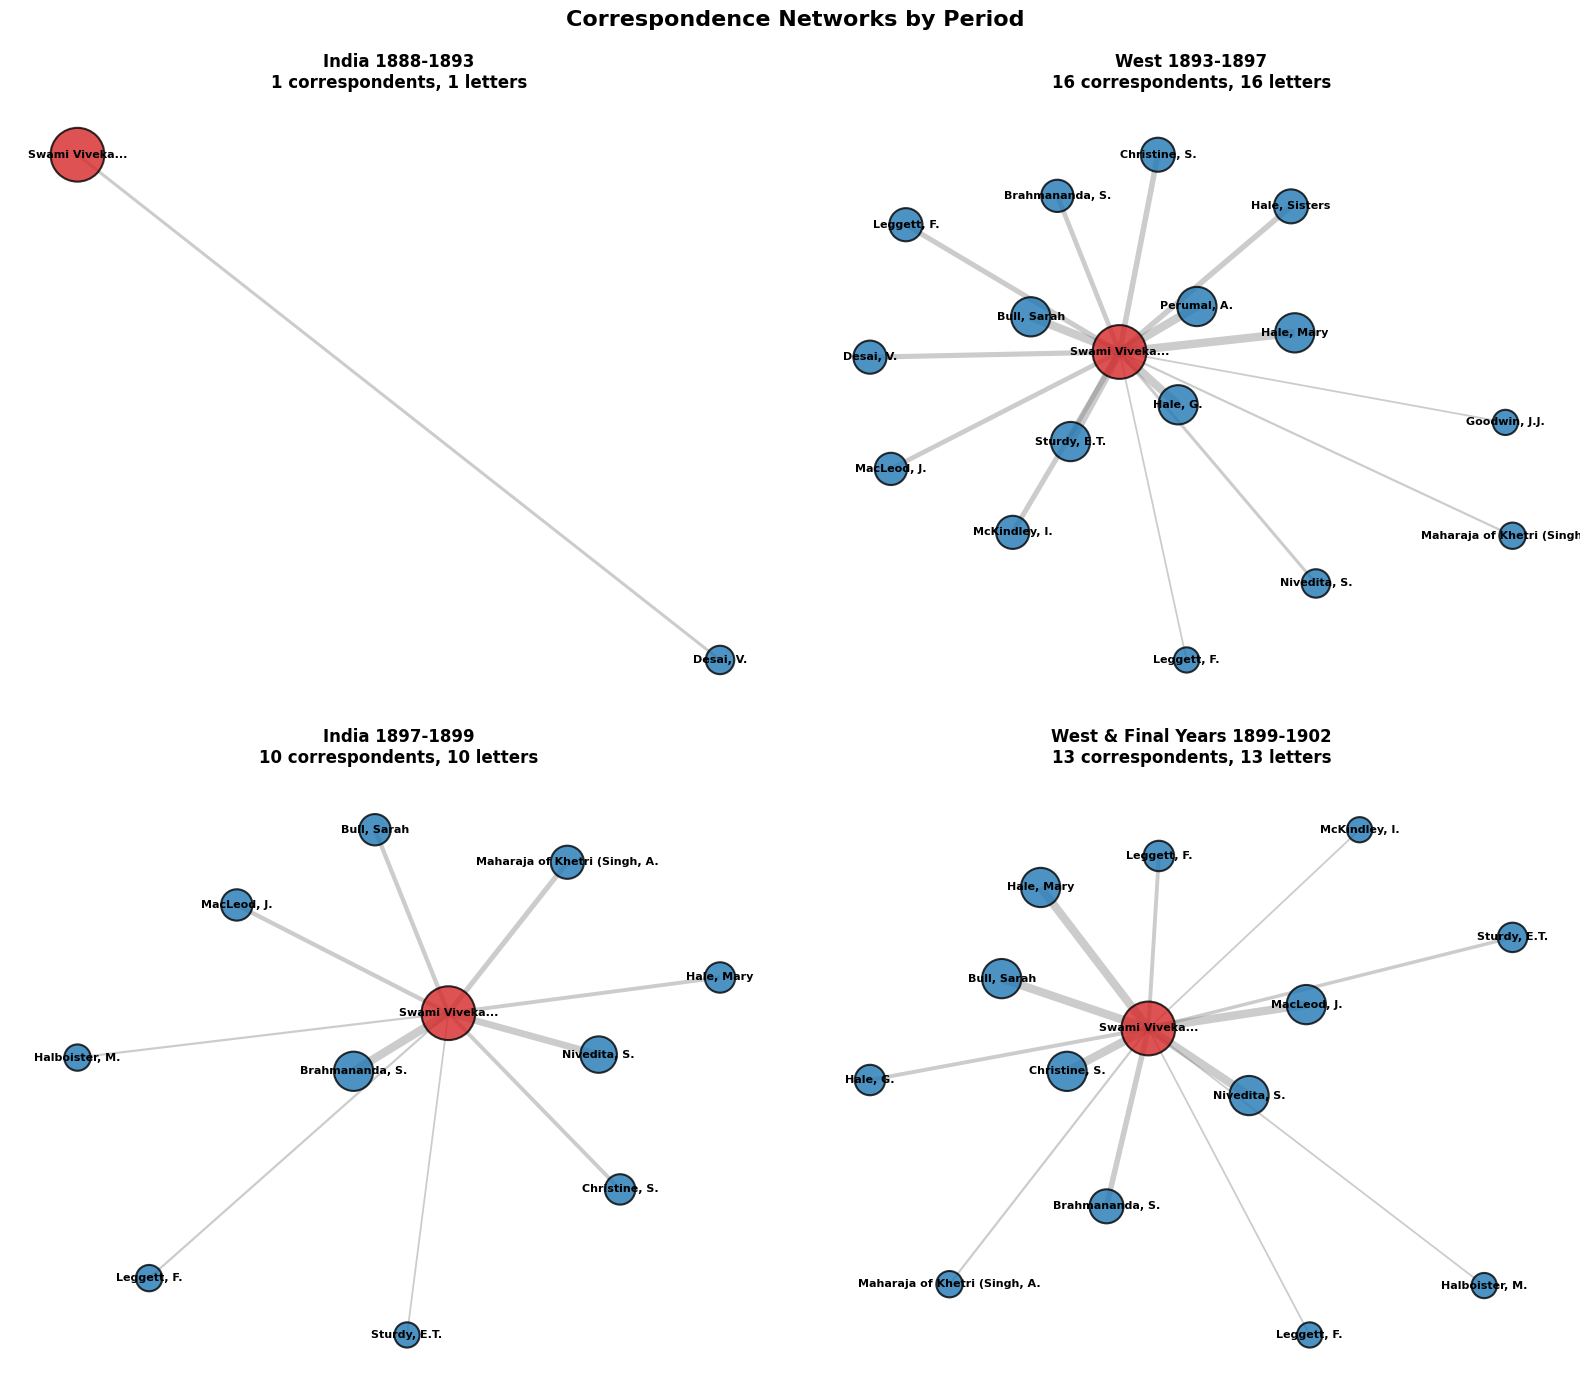

  ✓ Saved: correspondence_networks_by_period.png

[VIZ 2/5] Creating co-mention network visualizations...


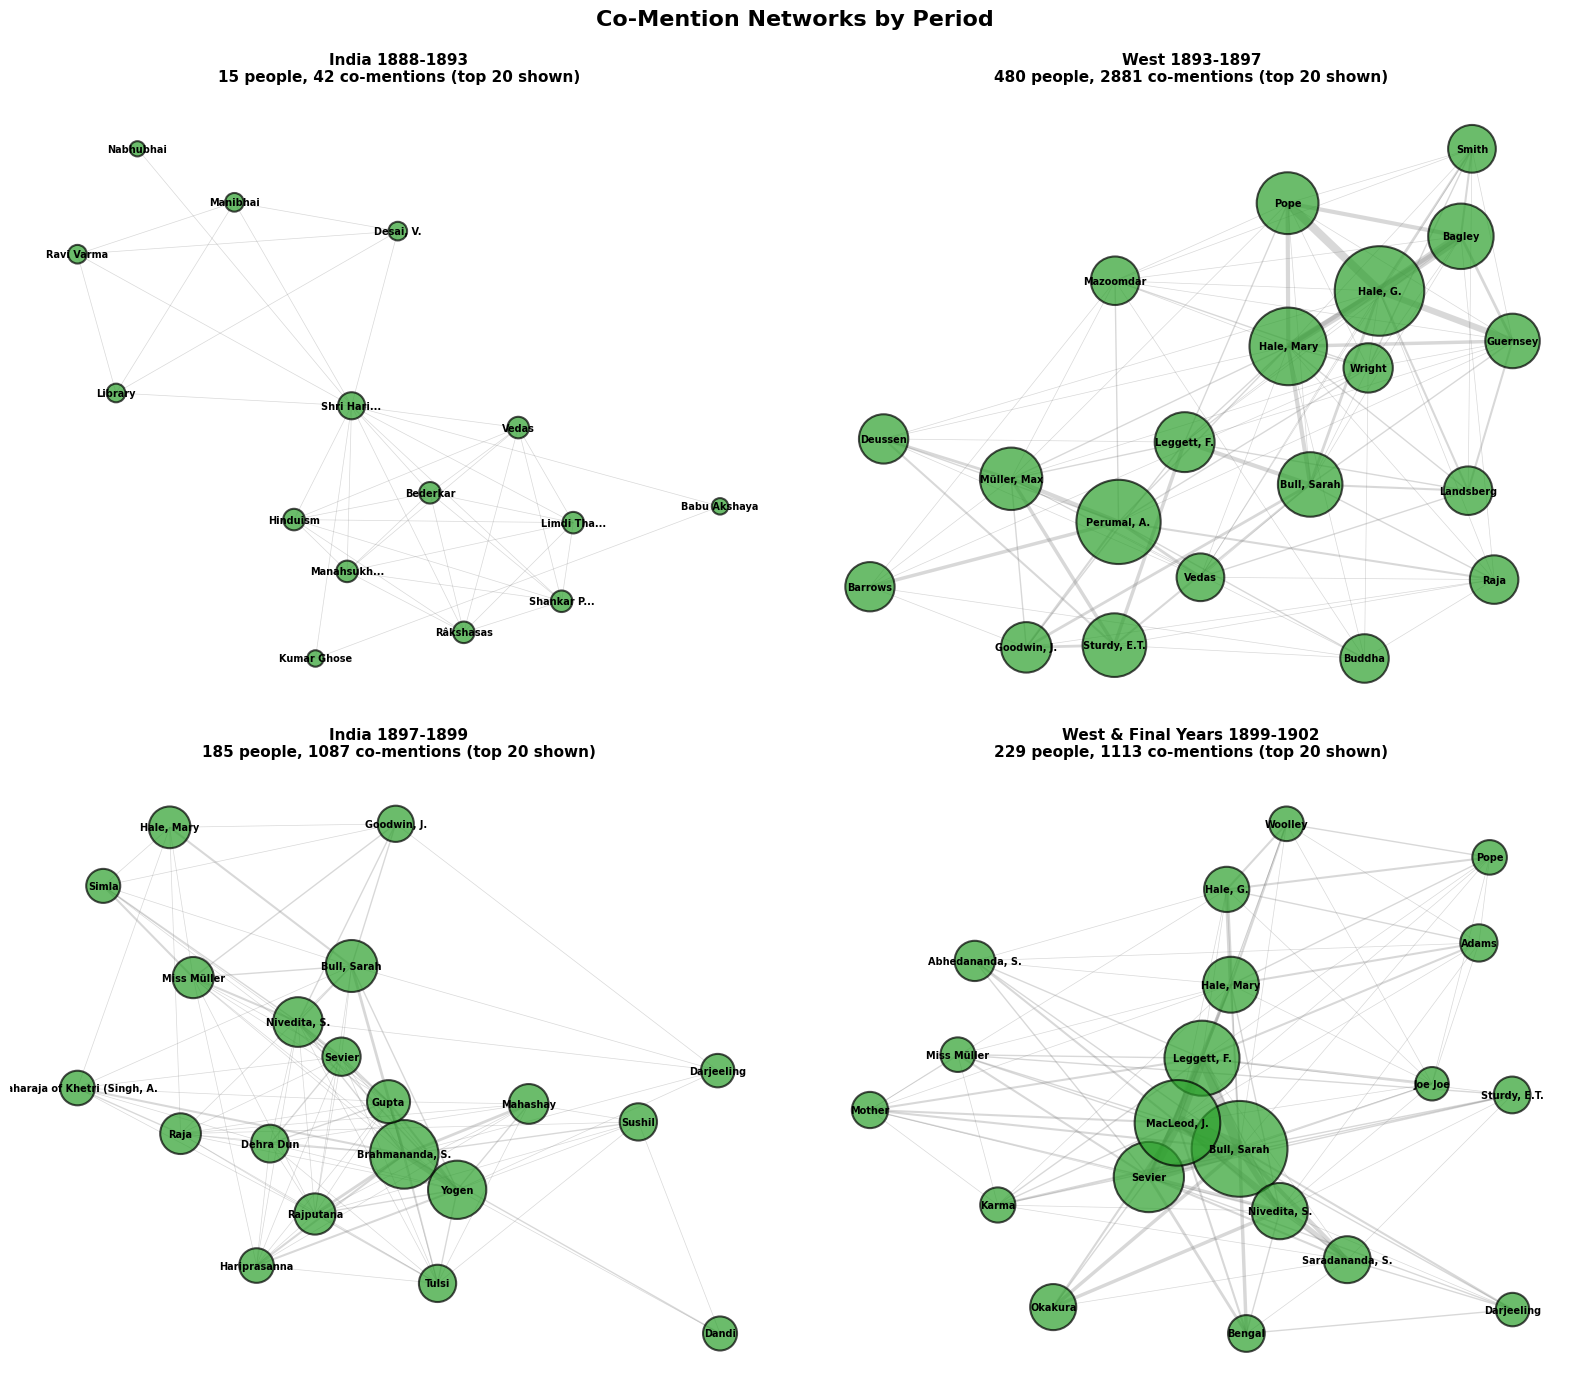

  ✓ Saved: comention_networks_by_period.png

[VIZ 3/5] Creating co-mention heatmap...


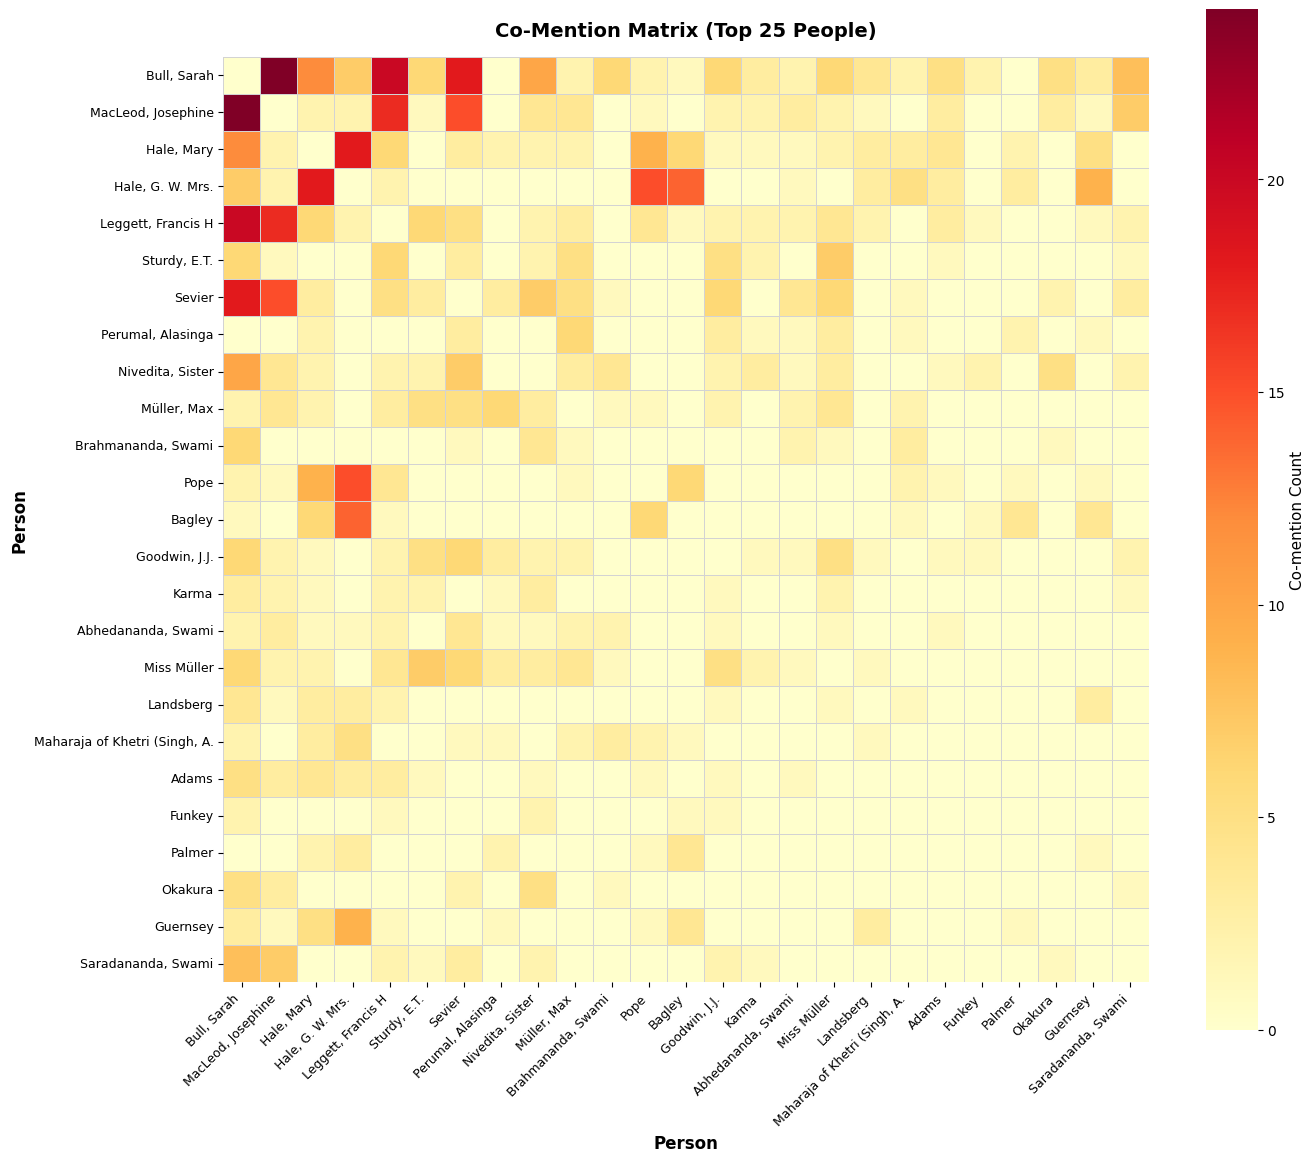

  ✓ Saved: comention_heatmap.png

[VIZ 4/5] Creating top correspondents bar chart...


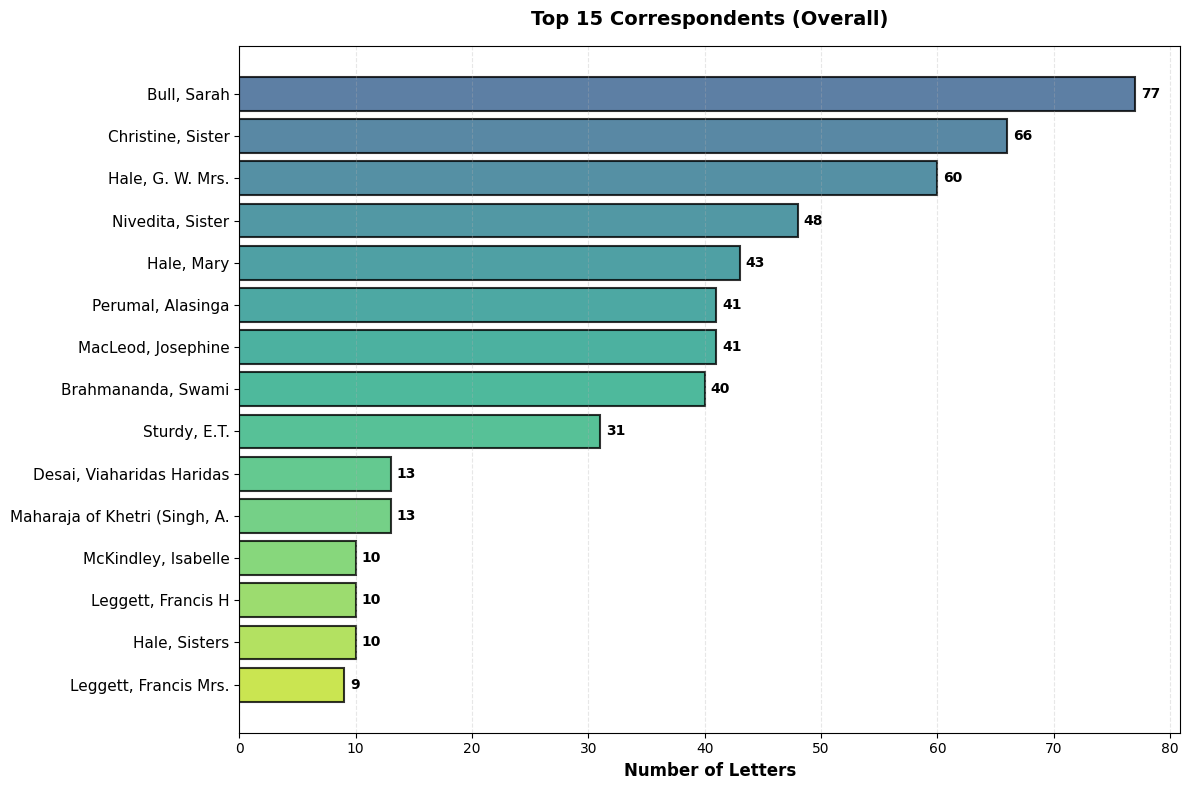

  ✓ Saved: top_correspondents_overall.png

[VIZ 5/5] Creating temporal evolution visualization...


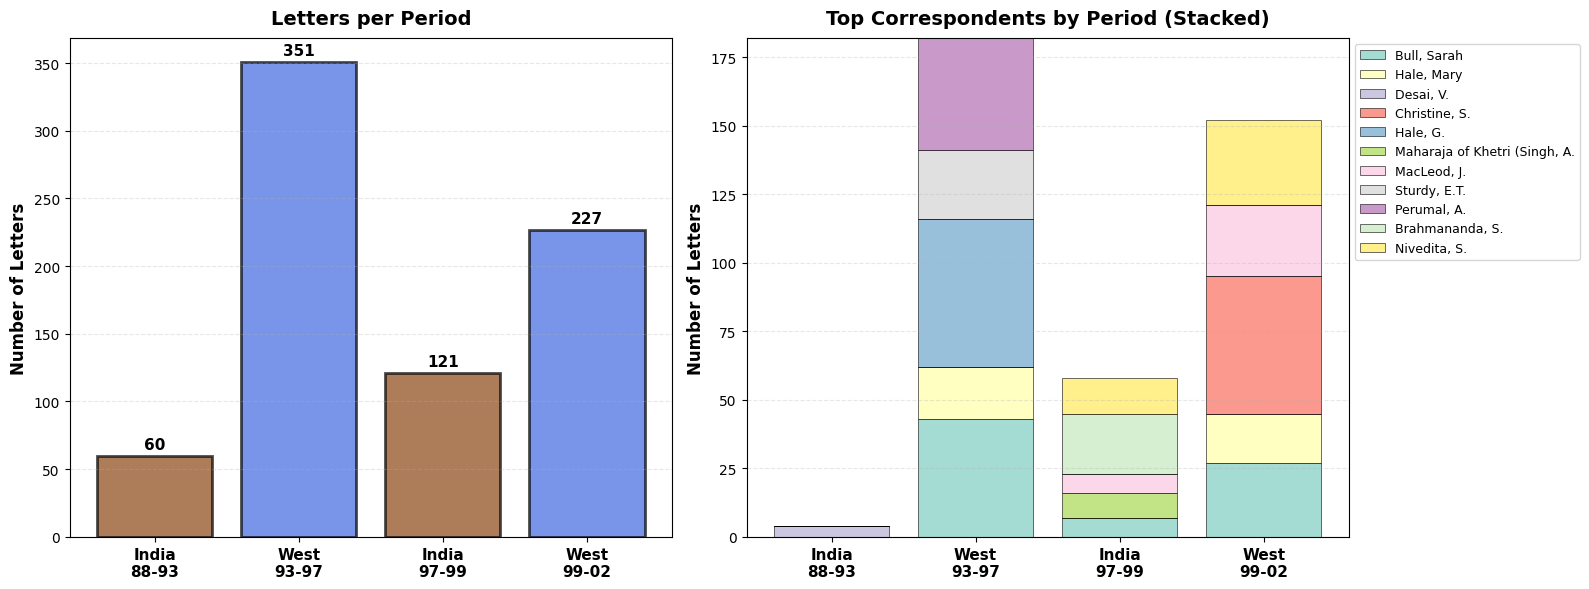

  ✓ Saved: temporal_evolution.png

VISUALIZATION COMPLETE
Generated files:
  1. correspondence_networks_by_period.png
  2. comention_networks_by_period.png
  3. comention_heatmap.png
  4. top_correspondents_overall.png
  5. temporal_evolution.png


In [17]:
# ============================================================================
# NETWORK VISUALIZATIONS
# Creates publication-quality network visualizations
# ============================================================================

import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import seaborn as sns
from matplotlib.patches import Rectangle
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("CREATING NETWORK VISUALIZATIONS")
print("="*80)

# Set style for publication quality
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['legend.fontsize'] = 9
plt.rcParams['figure.dpi'] = 100

# Helper function to abbreviate names
def abbreviate_name(name, max_length=20):
    """Abbreviate long names for visualization"""
    if len(name) <= max_length:
        return name
    parts = name.split(',')
    if len(parts) >= 2:
        # "Last, First" -> "Last, F."
        return f"{parts[0]}, {parts[1].strip()[0]}."
    return name[:max_length-3] + "..."

# ============================================================================
# VISUALIZATION 1: CORRESPONDENCE NETWORKS BY PERIOD (4 subplots)
# ============================================================================
print("\n[VIZ 1/5] Creating correspondence network visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(16, 14))
fig.suptitle('Correspondence Networks by Period', fontsize=16, fontweight='bold', y=0.995)

periods = sorted([p for p in correspondence_networks.keys()])
axes_flat = axes.flatten()

for idx, period in enumerate(periods):
    ax = axes_flat[idx]
    G = correspondence_networks[period]

    if G.number_of_nodes() > 1:
        # Create layout
        pos = nx.spring_layout(G, k=2, iterations=50, seed=42)

        # Node sizes based on letter count
        node_sizes = []
        for node in G.nodes():
            if node == 'Swami Vivekananda':
                node_sizes.append(1500)
            else:
                weight = G['Swami Vivekananda'][node]['weight']
                # Scale: 3-15 letters -> 300-800 size
                size = 300 + min(weight * 30, 500)
                node_sizes.append(size)

        # Edge widths based on letter count
        edge_widths = []
        for u, v in G.edges():
            weight = G[u][v]['weight']
            width = 1 + min(weight * 0.3, 5)
            edge_widths.append(width)

        # Node colors
        node_colors = ['#d62728' if node == 'Swami Vivekananda' else '#1f77b4'
                      for node in G.nodes()]

        # Draw network
        nx.draw_networkx_edges(G, pos, ax=ax, width=edge_widths, alpha=0.4,
                             edge_color='gray')
        nx.draw_networkx_nodes(G, pos, ax=ax, node_size=node_sizes,
                             node_color=node_colors, alpha=0.8,
                             edgecolors='black', linewidths=1.5)

        # Labels
        labels = {node: abbreviate_name(node, 15) for node in G.nodes()}
        nx.draw_networkx_labels(G, pos, labels, ax=ax, font_size=8,
                               font_weight='bold')

        # Title with stats
        n_correspondents = G.number_of_nodes() - 1
        n_letters = G.number_of_edges()
        ax.set_title(f"{period_labels[period]}\n{n_correspondents} correspondents, {n_letters} letters",
                    fontsize=12, fontweight='bold', pad=10)
    else:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center', fontsize=12)
        ax.set_title(period_labels[period], fontsize=12, fontweight='bold')

    ax.axis('off')

plt.tight_layout()
plt.savefig('correspondence_networks_by_period.png', dpi=150, bbox_inches='tight')
plt.show()

print("  ✓ Saved: correspondence_networks_by_period.png")

# ============================================================================
# VISUALIZATION 2: CO-MENTION NETWORKS BY PERIOD (4 subplots)
# ============================================================================
if len(comention_networks) > 0:
    print("\n[VIZ 2/5] Creating co-mention network visualizations...")

    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    fig.suptitle('Co-Mention Networks by Period', fontsize=16, fontweight='bold', y=0.995)

    axes_flat = axes.flatten()

    for idx, period in enumerate(periods):
        ax = axes_flat[idx]

        if period in comention_networks:
            G = comention_networks[period]

            if G.number_of_nodes() > 1 and G.number_of_edges() > 0:
                # Filter to top nodes by degree
                degrees = dict(G.degree(weight='weight'))
                top_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:20]
                top_node_names = [node for node, deg in top_nodes]

                # Subgraph with top nodes
                G_sub = G.subgraph(top_node_names).copy()

                # Layout
                pos = nx.spring_layout(G_sub, k=1.5, iterations=50, seed=42)

                # Node sizes by degree
                node_sizes = [100 + degrees[node] * 20 for node in G_sub.nodes()]

                # Edge widths by weight
                edge_widths = [G_sub[u][v]['weight'] * 0.5 for u, v in G_sub.edges()]

                # Draw
                nx.draw_networkx_edges(G_sub, pos, ax=ax, width=edge_widths,
                                     alpha=0.3, edge_color='gray')
                nx.draw_networkx_nodes(G_sub, pos, ax=ax, node_size=node_sizes,
                                     node_color='#2ca02c', alpha=0.7,
                                     edgecolors='black', linewidths=1.5)

                # Labels
                labels = {node: abbreviate_name(node, 12) for node in G_sub.nodes()}
                nx.draw_networkx_labels(G_sub, pos, labels, ax=ax, font_size=7,
                                       font_weight='bold')

                # Title
                n_nodes = G.number_of_nodes()
                n_edges = G.number_of_edges()
                ax.set_title(f"{period_labels[period]}\n{n_nodes} people, {n_edges} co-mentions (top 20 shown)",
                           fontsize=11, fontweight='bold', pad=10)
            else:
                ax.text(0.5, 0.5, 'No co-mentions', ha='center', va='center', fontsize=12)
                ax.set_title(period_labels[period], fontsize=12, fontweight='bold')
        else:
            ax.text(0.5, 0.5, 'No data', ha='center', va='center', fontsize=12)
            ax.set_title(period_labels[period], fontsize=12, fontweight='bold')

        ax.axis('off')

    plt.tight_layout()
    plt.savefig('comention_networks_by_period.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("  ✓ Saved: comention_networks_by_period.png")

# ============================================================================
# VISUALIZATION 3: CO-MENTION HEATMAP
# ============================================================================
if comention_matrix is not None and len(comention_matrix) > 0:
    print("\n[VIZ 3/5] Creating co-mention heatmap...")

    fig, ax = plt.subplots(figsize=(14, 12))

    # Abbreviate names for readability
    abbrev_names = [abbreviate_name(name, 18) for name in comention_matrix.index]

    # Create heatmap
    sns.heatmap(comention_matrix,
                xticklabels=abbrev_names,
                yticklabels=abbrev_names,
                cmap='YlOrRd',
                annot=False,
                fmt='d',
                cbar_kws={'label': 'Co-mention Count'},
                linewidths=0.5,
                linecolor='lightgray',
                square=True,
                ax=ax)

    ax.set_title('Co-Mention Matrix (Top 25 People)',
                fontsize=14, fontweight='bold', pad=15)
    ax.set_xlabel('Person', fontsize=12, fontweight='bold')
    ax.set_ylabel('Person', fontsize=12, fontweight='bold')

    plt.xticks(rotation=45, ha='right', fontsize=9)
    plt.yticks(rotation=0, fontsize=9)

    plt.tight_layout()
    plt.savefig('comention_heatmap.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("  ✓ Saved: comention_heatmap.png")

# ============================================================================
# VISUALIZATION 4: TOP CORRESPONDENTS BAR CHART
# ============================================================================
print("\n[VIZ 4/5] Creating top correspondents bar chart...")

# Get overall top correspondents
all_letter_counts = all_letters[
    all_letters['Audience_clean'].isin(extended_focus_correspondents)
]['Audience_clean'].value_counts().head(15)

fig, ax = plt.subplots(figsize=(12, 8))

y_pos = np.arange(len(all_letter_counts))
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(all_letter_counts)))

bars = ax.barh(y_pos, all_letter_counts.values, color=colors,
               alpha=0.8, edgecolor='black', linewidth=1.5)

# Labels
abbrev_names = [abbreviate_name(name, 25) for name in all_letter_counts.index]
ax.set_yticks(y_pos)
ax.set_yticklabels(abbrev_names, fontsize=11)
ax.invert_yaxis()

# Add value labels on bars
for i, v in enumerate(all_letter_counts.values):
    ax.text(v + 0.5, i, str(v), va='center', fontsize=10, fontweight='bold')

ax.set_xlabel('Number of Letters', fontsize=12, fontweight='bold')
ax.set_title('Top 15 Correspondents (Overall)', fontsize=14, fontweight='bold', pad=15)
ax.grid(axis='x', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('top_correspondents_overall.png', dpi=150, bbox_inches='tight')
plt.show()

print("  ✓ Saved: top_correspondents_overall.png")

# ============================================================================
# VISUALIZATION 5: TEMPORAL EVOLUTION (Letters per Period)
# ============================================================================
print("\n[VIZ 5/5] Creating temporal evolution visualization...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Letters per period
period_counts = all_letters[all_letters['period'] != 'Unknown']['period'].value_counts()
period_counts = period_counts.reindex(periods, fill_value=0)

period_names_short = ['India\n88-93', 'West\n93-97', 'India\n97-99', 'West\n99-02']
colors_period = ['#8B4513', '#4169E1', '#8B4513', '#4169E1']

bars = ax1.bar(range(len(periods)), period_counts.values,
               color=colors_period, alpha=0.7, edgecolor='black', linewidth=2)

ax1.set_xticks(range(len(periods)))
ax1.set_xticklabels(period_names_short, fontsize=11, fontweight='bold')
ax1.set_ylabel('Number of Letters', fontsize=12, fontweight='bold')
ax1.set_title('Letters per Period', fontsize=14, fontweight='bold', pad=10)
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels
for i, v in enumerate(period_counts.values):
    ax1.text(i, v + 5, str(v), ha='center', fontsize=11, fontweight='bold')

# Plot 2: Top 5 correspondents per period (stacked)
top_5_by_period = {}
for period in periods:
    period_letters = all_letters[
        (all_letters['period'] == period) &
        (all_letters['Audience_clean'].isin(extended_focus_correspondents))
    ]
    top_5 = period_letters['Audience_clean'].value_counts().head(5)
    top_5_by_period[period] = top_5

# Get unique top correspondents across all periods
all_top_correspondents = set()
for top_5 in top_5_by_period.values():
    all_top_correspondents.update(top_5.index)

# Create stacked bar chart
bottom = np.zeros(len(periods))
colors_correspondents = plt.cm.Set3(np.linspace(0, 1, len(all_top_correspondents)))

for i, correspondent in enumerate(all_top_correspondents):
    values = []
    for period in periods:
        if correspondent in top_5_by_period[period]:
            values.append(top_5_by_period[period][correspondent])
        else:
            values.append(0)

    ax2.bar(range(len(periods)), values, bottom=bottom,
            label=abbreviate_name(correspondent, 15),
            color=colors_correspondents[i], alpha=0.8,
            edgecolor='black', linewidth=0.5)
    bottom += values

ax2.set_xticks(range(len(periods)))
ax2.set_xticklabels(period_names_short, fontsize=11, fontweight='bold')
ax2.set_ylabel('Number of Letters', fontsize=12, fontweight='bold')
ax2.set_title('Top Correspondents by Period (Stacked)', fontsize=14, fontweight='bold', pad=10)
ax2.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=9)
ax2.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('temporal_evolution.png', dpi=150, bbox_inches='tight')
plt.show()

print("  ✓ Saved: temporal_evolution.png")

# ============================================================================
# SUMMARY
# ============================================================================
print("\n" + "="*80)
print("VISUALIZATION COMPLETE")
print("="*80)
print("Generated files:")
print("  1. correspondence_networks_by_period.png")
if len(comention_networks) > 0:
    print("  2. comention_networks_by_period.png")
if comention_matrix is not None:
    print("  3. comention_heatmap.png")
print("  4. top_correspondents_overall.png")
print("  5. temporal_evolution.png")
print("="*80)

CORRECTED CO-MENTION NETWORKS - RECIPIENTS ONLY

[STEP 1] Filtering mentions to only actual recipients...
  Total unique recipients in corpus: 110
  Total mentions extracted: 2443
  Mentions of actual recipients: 739
  Unique recipients mentioned: 22

  Excluded mentions (non-recipients): 1704

  Top 10 excluded (non-recipient) names:
    - Sevier: 50 mentions
    - Müller, Max: 34 mentions
    - Pope: 26 mentions
    - Bagley: 25 mentions
    - Karma: 21 mentions
    - Miss Müller: 20 mentions
    - Landsberg: 20 mentions
    - Adams: 19 mentions
    - Funkey: 18 mentions
    - Palmer: 16 mentions

[STEP 2] Building corrected co-mention networks (recipients only)...
  Period1_India_1888-1893: 0 recipients, 0 co-mention edges
  Period2_West_1893-1897: 15 recipients, 29 co-mention edges
  Period3_India_1897-1899: 13 recipients, 25 co-mention edges
  Period4_West_Final_1899-1902: 14 recipients, 39 co-mention edges

[STEP 3] Building corrected co-mention matrix (recipients only)...
  Buil

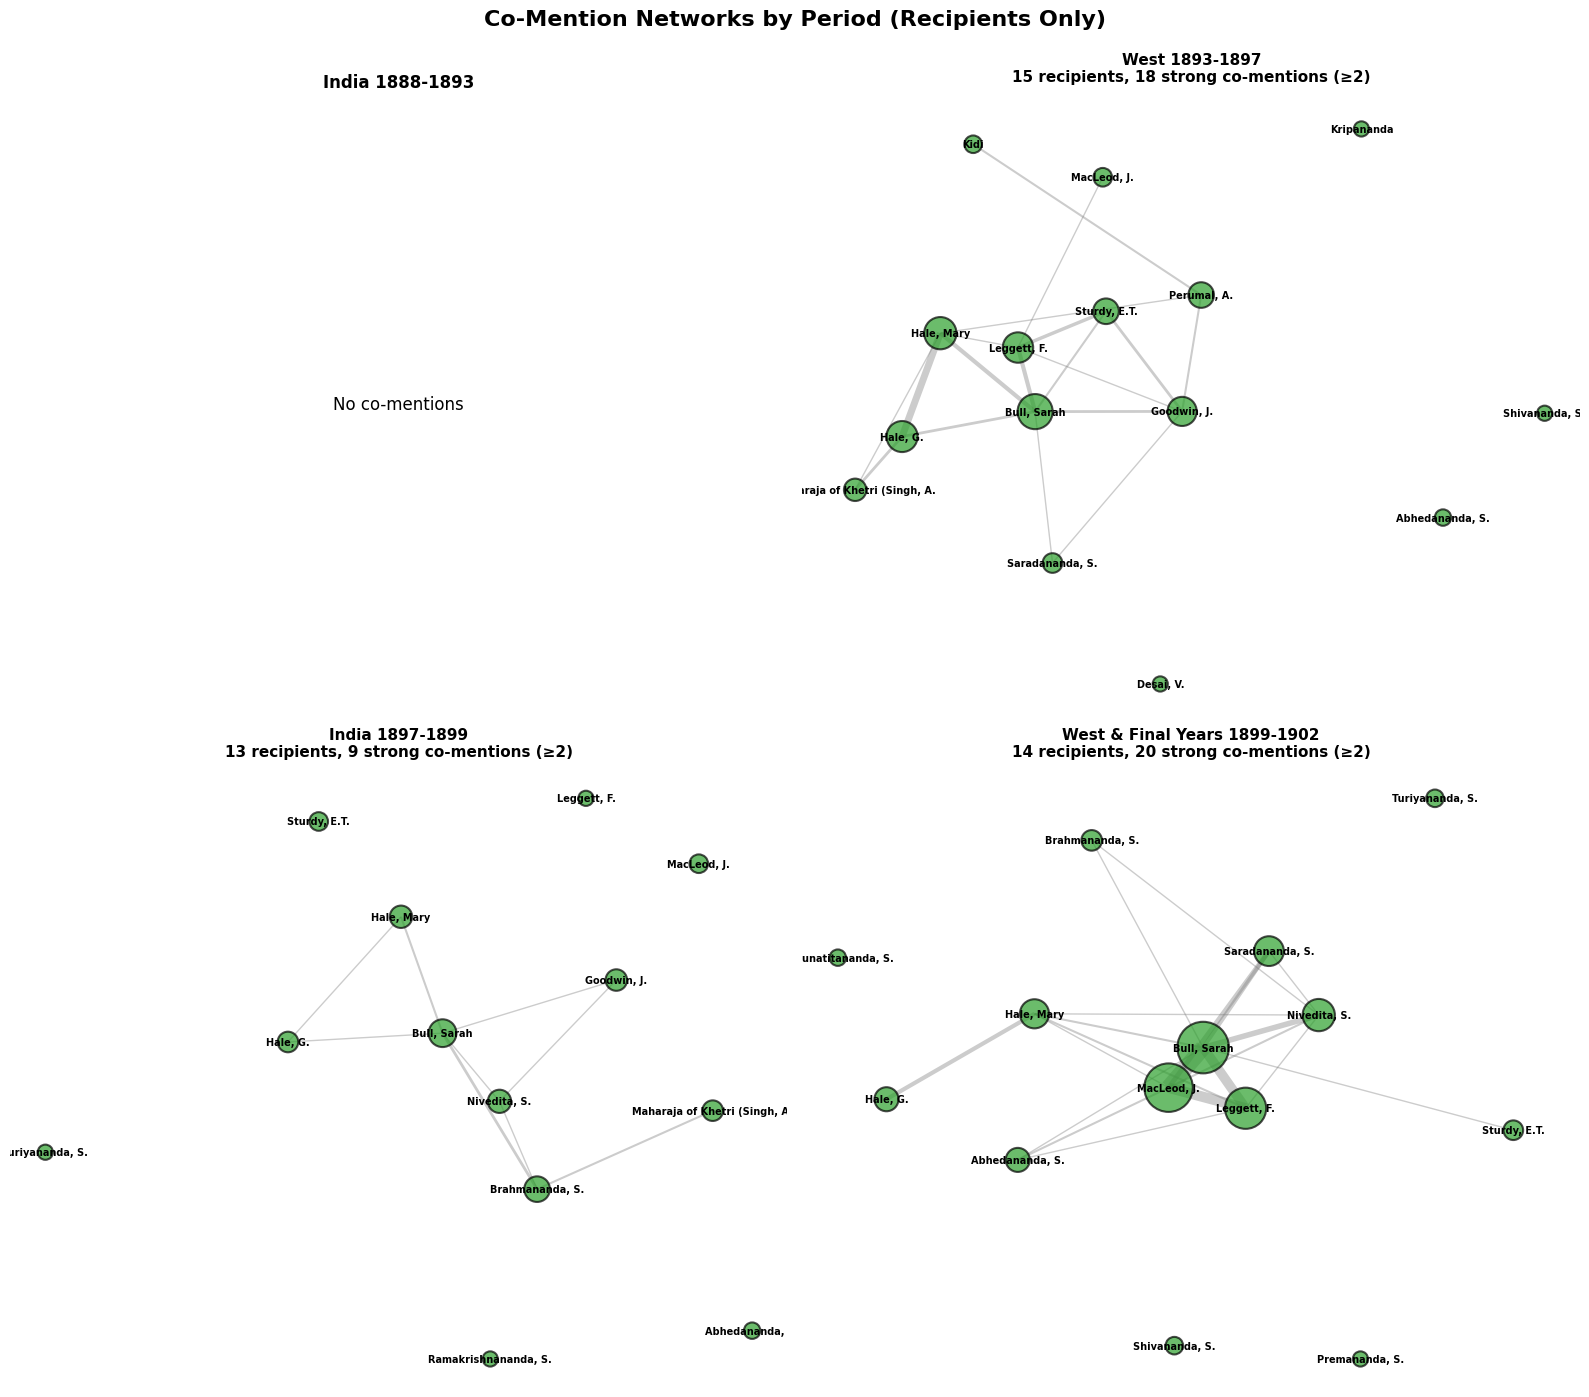

  ✓ Saved: comention_networks_recipients_only.png

[VIZ 2/3] Creating corrected co-mention heatmap...


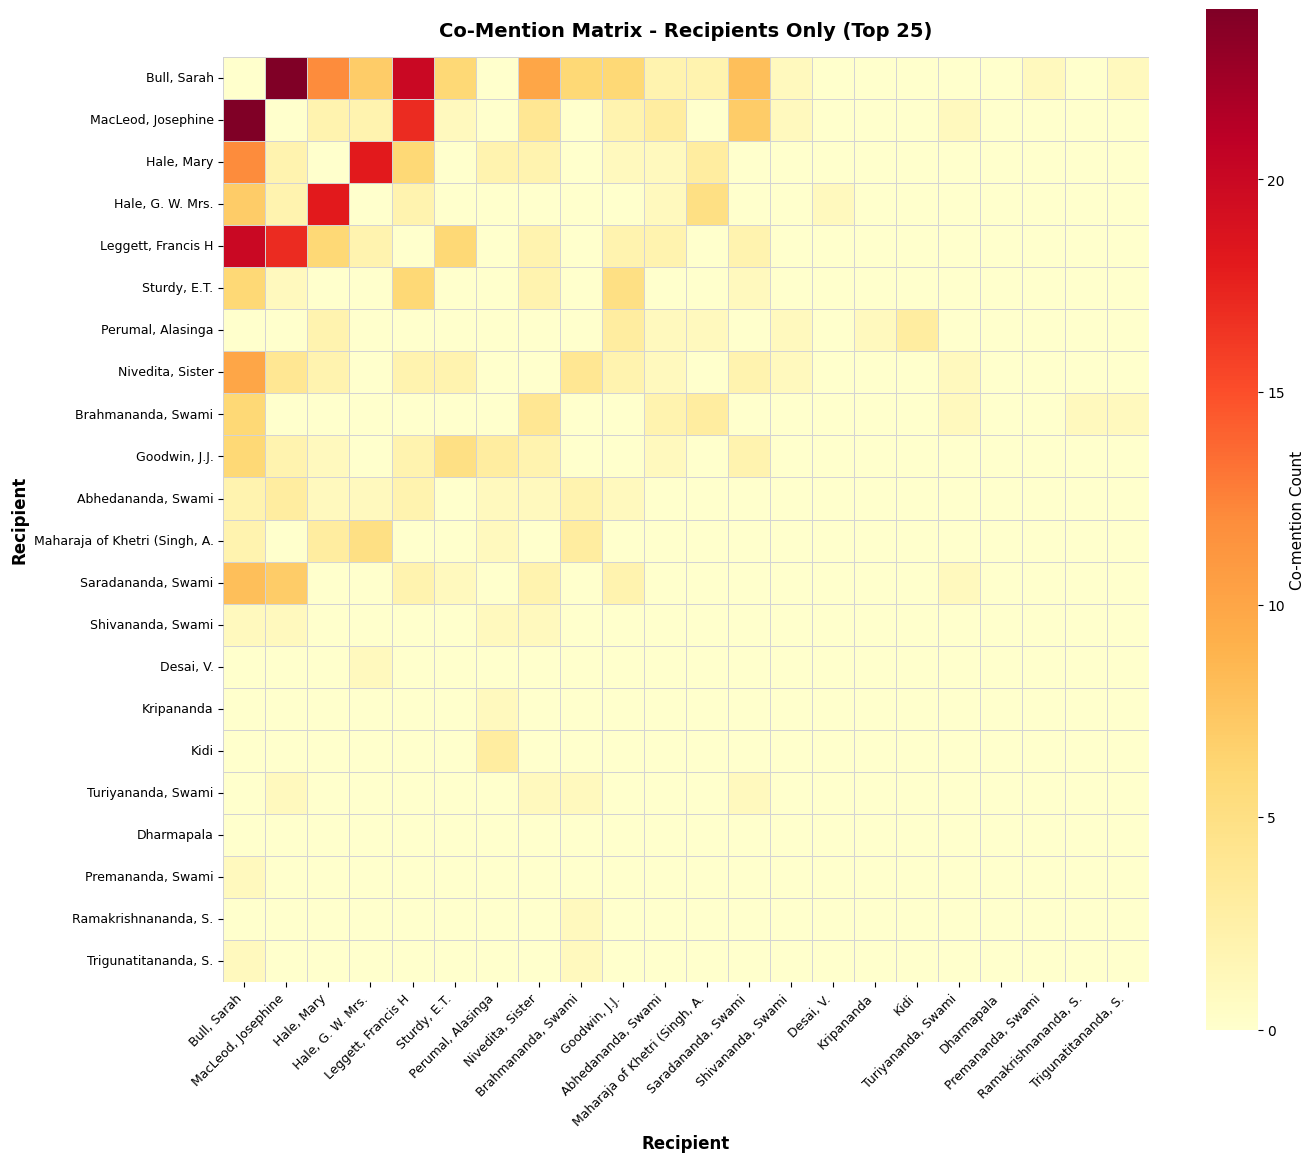

  ✓ Saved: comention_heatmap_recipients_only.png

[VIZ 3/3] Creating top co-mention pairs visualization...


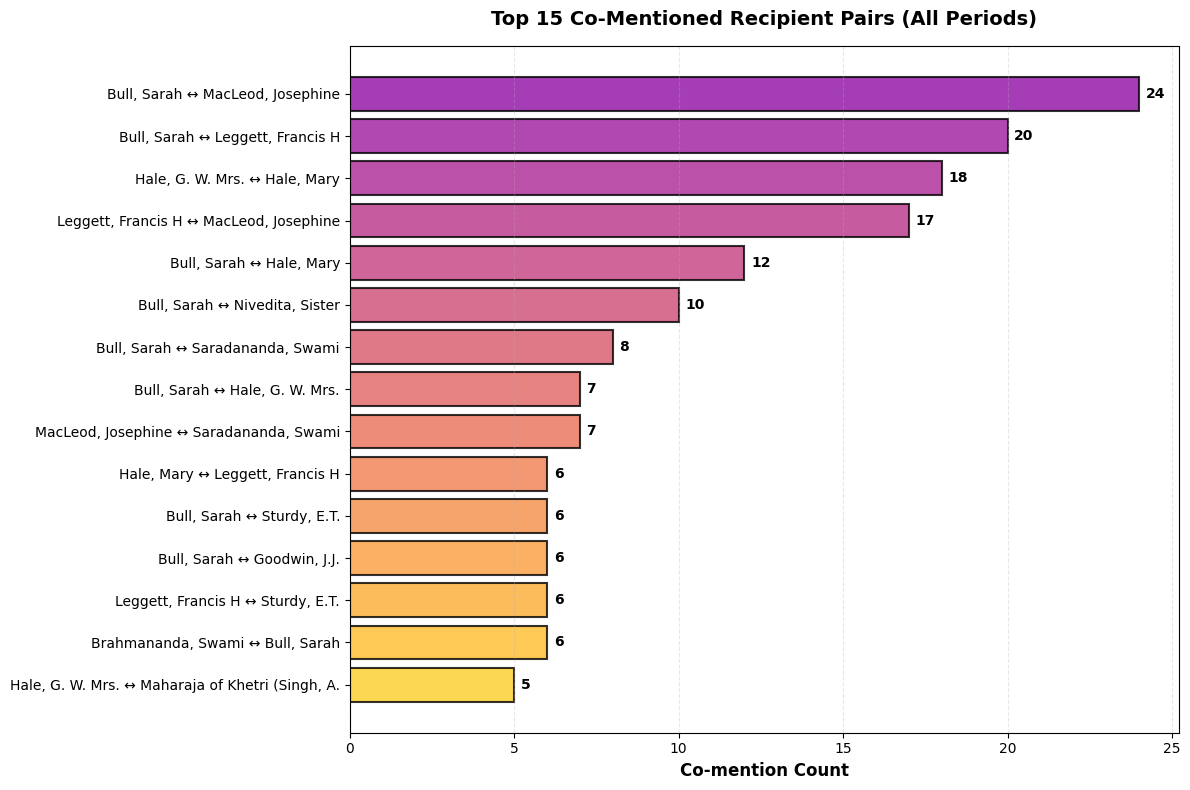

  ✓ Saved: top_comention_pairs_recipients.png

CORRECTED CO-MENTION ANALYSIS COMPLETE
✓ Filtered to recipients only: 739 mentions
✓ Unique recipients mentioned: 22
✓ Co-mention networks created for 4 periods
✓ Top co-mentioned pair: Bull, Sarah ↔ MacLeod, Josephine (24 times)

Generated files:
  1. comention_networks_recipients_only.png
  2. comention_heatmap_recipients_only.png
  3. top_comention_pairs_recipients.png


In [18]:
# ============================================================================
# CORRECTED CO-MENTION NETWORKS - RECIPIENTS ONLY
# Only tracks mentions of actual letter recipients (audience_clean)
# Fixes the issue of including all NER entities like Buddha, Deussen, etc.
# ============================================================================

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("CORRECTED CO-MENTION NETWORKS - RECIPIENTS ONLY")
print("="*80)

# ============================================================================
# STEP 1: FILTER MENTIONS TO ONLY RECIPIENTS
# ============================================================================
print("\n[STEP 1] Filtering mentions to only actual recipients...")

# Get all unique recipients from audience_clean
all_recipients = set(all_letters['Audience_clean'].dropna().unique())

print(f"  Total unique recipients in corpus: {len(all_recipients)}")
print(f"  Total mentions extracted: {len(resolved_mentions_df)}")

# Filter resolved_mentions_df to only include people who are recipients
# Use the resolved names, but check if they appear in audience_clean
recipient_mentions_df = resolved_mentions_df[
    resolved_mentions_df['resolved_name'].isin(all_recipients)
].copy()

print(f"  Mentions of actual recipients: {len(recipient_mentions_df)}")
print(f"  Unique recipients mentioned: {recipient_mentions_df['resolved_name'].nunique()}")

# Show what we filtered out
excluded_count = len(resolved_mentions_df) - len(recipient_mentions_df)
print(f"\n  Excluded mentions (non-recipients): {excluded_count}")

if excluded_count > 0:
    excluded_names = resolved_mentions_df[
        ~resolved_mentions_df['resolved_name'].isin(all_recipients)
    ]['resolved_name'].value_counts().head(10)

    print(f"\n  Top 10 excluded (non-recipient) names:")
    for name, count in excluded_names.items():
        print(f"    - {name}: {count} mentions")

# ============================================================================
# STEP 2: BUILD CORRECTED CO-MENTION NETWORKS BY PERIOD
# ============================================================================
print("\n[STEP 2] Building corrected co-mention networks (recipients only)...")

comention_networks_corrected = {}

for period in sorted(all_letters['period'].unique()):
    if period == 'Unknown':
        continue

    # Get mentions from this period (recipients only)
    period_mentions = recipient_mentions_df[recipient_mentions_df['period'] == period]

    # Build co-mention network
    G = nx.Graph()
    comention_counts = defaultdict(int)

    for letter_id in period_mentions['letter_id'].unique():
        letter_mentions = period_mentions[period_mentions['letter_id'] == letter_id]
        mentioned_people = letter_mentions['resolved_name'].unique()

        # Create edges between all pairs of recipients mentioned in same letter
        for i, person1 in enumerate(mentioned_people):
            for person2 in mentioned_people[i+1:]:
                # Sort to avoid duplicate edges
                pair = tuple(sorted([person1, person2]))
                comention_counts[pair] += 1

    # Add edges to graph
    for (person1, person2), weight in comention_counts.items():
        G.add_edge(person1, person2, weight=weight)

    comention_networks_corrected[period] = G
    print(f"  {period}: {G.number_of_nodes()} recipients, {G.number_of_edges()} co-mention edges")

# ============================================================================
# STEP 3: BUILD CORRECTED OVERALL CO-MENTION MATRIX
# ============================================================================
print("\n[STEP 3] Building corrected co-mention matrix (recipients only)...")

# Get top mentioned recipients
top_mentioned_recipients = recipient_mentions_df['resolved_name'].value_counts().head(25).index.tolist()

# Build co-mention matrix
comention_matrix_corrected = pd.DataFrame(0, index=top_mentioned_recipients, columns=top_mentioned_recipients)

for letter_id in recipient_mentions_df['letter_id'].unique():
    letter_mentions = recipient_mentions_df[recipient_mentions_df['letter_id'] == letter_id]
    mentioned = letter_mentions['resolved_name'].unique()

    for person1 in mentioned:
        if person1 in top_mentioned_recipients:
            for person2 in mentioned:
                if person2 in top_mentioned_recipients and person1 != person2:
                    comention_matrix_corrected.loc[person1, person2] += 1

print(f"  Built {len(top_mentioned_recipients)}x{len(top_mentioned_recipients)} co-mention matrix")

# ============================================================================
# STEP 4: STATISTICS COMPARISON
# ============================================================================
print("\n[STEP 4] Comparing corrected vs original networks...")

print("\nTop 15 Most Mentioned Recipients:")
top_15_recipients = recipient_mentions_df['resolved_name'].value_counts().head(15)
for rank, (name, count) in enumerate(top_15_recipients.items(), 1):
    print(f"  {rank:2d}. {name:<35} {count:4d} mentions")

# ============================================================================
# VISUALIZATION 1: CORRECTED CO-MENTION NETWORKS BY PERIOD
# ============================================================================
print("\n[VIZ 1/3] Creating corrected co-mention network visualizations...")

def abbreviate_name(name, max_length=20):
    if len(name) <= max_length:
        return name
    parts = name.split(',')
    if len(parts) >= 2:
        return f"{parts[0]}, {parts[1].strip()[0]}."
    return name[:max_length-3] + "..."

plt.rcParams['font.size'] = 10
plt.rcParams['figure.dpi'] = 100

fig, axes = plt.subplots(2, 2, figsize=(16, 14))
fig.suptitle('Co-Mention Networks by Period (Recipients Only)', fontsize=16, fontweight='bold', y=0.995)

periods = sorted([p for p in comention_networks_corrected.keys()])
axes_flat = axes.flatten()

period_labels = {
    'Period1_India_1888-1893': 'India 1888-1893',
    'Period2_West_1893-1897': 'West 1893-1897',
    'Period3_India_1897-1899': 'India 1897-1899',
    'Period4_West_Final_1899-1902': 'West & Final Years 1899-1902'
}

for idx, period in enumerate(periods):
    ax = axes_flat[idx]
    G = comention_networks_corrected[period]

    if G.number_of_nodes() > 1 and G.number_of_edges() > 0:
        # Filter to top nodes by degree
        degrees = dict(G.degree(weight='weight'))
        top_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:15]
        top_node_names = [node for node, deg in top_nodes]

        # Subgraph with top nodes
        G_sub = G.subgraph(top_node_names).copy()

        if G_sub.number_of_nodes() > 0:
            # Layout
            pos = nx.spring_layout(G_sub, k=1.5, iterations=50, seed=42)

            # Node sizes by degree
            node_sizes = [100 + degrees[node] * 20 for node in G_sub.nodes()]

            # Edge widths by weight (only show edges with weight >= 2)
            edges_to_draw = [(u, v) for u, v in G_sub.edges() if G_sub[u][v]['weight'] >= 2]
            edge_widths = [G_sub[u][v]['weight'] * 0.5 for u, v in edges_to_draw]

            # Draw
            if len(edges_to_draw) > 0:
                nx.draw_networkx_edges(G_sub, pos, ax=ax, edgelist=edges_to_draw,
                                     width=edge_widths, alpha=0.4, edge_color='gray')

            nx.draw_networkx_nodes(G_sub, pos, ax=ax, node_size=node_sizes,
                                 node_color='#2ca02c', alpha=0.7,
                                 edgecolors='black', linewidths=1.5)

            # Labels
            labels = {node: abbreviate_name(node, 12) for node in G_sub.nodes()}
            nx.draw_networkx_labels(G_sub, pos, labels, ax=ax, font_size=7,
                                   font_weight='bold')

            # Title
            n_nodes = G.number_of_nodes()
            n_edges = len([1 for u, v in G.edges() if G[u][v]['weight'] >= 2])
            ax.set_title(f"{period_labels[period]}\n{n_nodes} recipients, {n_edges} strong co-mentions (≥2)",
                       fontsize=11, fontweight='bold', pad=10)
        else:
            ax.text(0.5, 0.5, 'No strong co-mentions', ha='center', va='center', fontsize=12)
            ax.set_title(period_labels[period], fontsize=12, fontweight='bold')
    else:
        ax.text(0.5, 0.5, 'No co-mentions', ha='center', va='center', fontsize=12)
        ax.set_title(period_labels[period], fontsize=12, fontweight='bold')

    ax.axis('off')

plt.tight_layout()
plt.savefig('comention_networks_recipients_only.png', dpi=150, bbox_inches='tight')
plt.show()

print("  ✓ Saved: comention_networks_recipients_only.png")

# ============================================================================
# VISUALIZATION 2: CORRECTED CO-MENTION HEATMAP
# ============================================================================
print("\n[VIZ 2/3] Creating corrected co-mention heatmap...")

fig, ax = plt.subplots(figsize=(14, 12))

# Abbreviate names for readability
abbrev_names = [abbreviate_name(name, 22) for name in comention_matrix_corrected.index]

# Create heatmap
sns.heatmap(comention_matrix_corrected,
            xticklabels=abbrev_names,
            yticklabels=abbrev_names,
            cmap='YlOrRd',
            annot=False,
            cbar_kws={'label': 'Co-mention Count'},
            linewidths=0.5,
            linecolor='lightgray',
            square=True,
            ax=ax)

ax.set_title('Co-Mention Matrix - Recipients Only (Top 25)',
            fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('Recipient', fontsize=12, fontweight='bold')
ax.set_ylabel('Recipient', fontsize=12, fontweight='bold')

plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)

plt.tight_layout()
plt.savefig('comention_heatmap_recipients_only.png', dpi=150, bbox_inches='tight')
plt.show()

print("  ✓ Saved: comention_heatmap_recipients_only.png")

# ============================================================================
# VISUALIZATION 3: TOP CO-MENTION PAIRS
# ============================================================================
print("\n[VIZ 3/3] Creating top co-mention pairs visualization...")

# Extract all co-mention pairs across all periods
all_comention_pairs = []

for period, G in comention_networks_corrected.items():
    for u, v in G.edges():
        weight = G[u][v]['weight']
        all_comention_pairs.append({
            'person1': u,
            'person2': v,
            'weight': weight,
            'period': period
        })

comention_pairs_df = pd.DataFrame(all_comention_pairs)

# Aggregate across all periods
pair_totals = {}
for _, row in comention_pairs_df.iterrows():
    pair = tuple(sorted([row['person1'], row['person2']]))
    if pair not in pair_totals:
        pair_totals[pair] = 0
    pair_totals[pair] += row['weight']

# Sort and get top pairs
top_pairs = sorted(pair_totals.items(), key=lambda x: x[1], reverse=True)[:15]

fig, ax = plt.subplots(figsize=(12, 8))

# Prepare data for plotting
pair_labels = [f"{abbreviate_name(p1, 18)} ↔ {abbreviate_name(p2, 18)}"
               for (p1, p2), _ in top_pairs]
pair_values = [count for _, count in top_pairs]

y_pos = np.arange(len(pair_labels))
colors = plt.cm.plasma(np.linspace(0.3, 0.9, len(pair_labels)))

bars = ax.barh(y_pos, pair_values, color=colors, alpha=0.8,
               edgecolor='black', linewidth=1.5)

ax.set_yticks(y_pos)
ax.set_yticklabels(pair_labels, fontsize=10)
ax.invert_yaxis()

# Add value labels
for i, v in enumerate(pair_values):
    ax.text(v + 0.2, i, str(v), va='center', fontsize=10, fontweight='bold')

ax.set_xlabel('Co-mention Count', fontsize=12, fontweight='bold')
ax.set_title('Top 15 Co-Mentioned Recipient Pairs (All Periods)',
            fontsize=14, fontweight='bold', pad=15)
ax.grid(axis='x', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('top_comention_pairs_recipients.png', dpi=150, bbox_inches='tight')
plt.show()

print("  ✓ Saved: top_comention_pairs_recipients.png")

# ============================================================================
# SUMMARY
# ============================================================================
print("\n" + "="*80)
print("CORRECTED CO-MENTION ANALYSIS COMPLETE")
print("="*80)
print(f"✓ Filtered to recipients only: {len(recipient_mentions_df)} mentions")
print(f"✓ Unique recipients mentioned: {recipient_mentions_df['resolved_name'].nunique()}")
print(f"✓ Co-mention networks created for {len(comention_networks_corrected)} periods")
print(f"✓ Top co-mentioned pair: {top_pairs[0][0][0]} ↔ {top_pairs[0][0][1]} ({top_pairs[0][1]} times)")
print("\nGenerated files:")
print("  1. comention_networks_recipients_only.png")
print("  2. comention_heatmap_recipients_only.png")
print("  3. top_comention_pairs_recipients.png")
print("="*80)

# Store corrected networks for future use
comention_networks = comention_networks_corrected
comention_matrix = comention_matrix_corrected

CORRECTED CO-MENTION NETWORKS - COMPLETE VERSION

[STEP 1] Applying expanded nickname mapping...
  Applied 107 nickname mappings
  Total mentions: 2443
  Unique resolved names: 785

[STEP 2] Filtering to recipients and important people...
  Recipients: 110
  Important non-recipients added: 4
  Total people to track: 114
  Mentions of tracked people: 885
  Unique people mentioned: 26

  Top 10 excluded (non-tracked) names:
    - Pope: 26 mentions
    - Bagley: 25 mentions
    - Karma: 21 mentions
    - Landsberg: 20 mentions
    - Palmer: 16 mentions
    - Okakura: 15 mentions
    - Guernsey: 15 mentions
    - Hale: 14 mentions
    - Raja: 13 mentions
    - Mazoomdar: 13 mentions

[STEP 3] Building co-mention networks (tracked people only)...
  Period1_India_1888-1893: 0 people, 0 co-mention edges
  Period2_West_1893-1897: 19 people, 50 co-mention edges
  Period3_India_1897-1899: 17 people, 42 co-mention edges
  Period4_West_Final_1899-1902: 18 people, 63 co-mention edges

[STEP 4] Buil

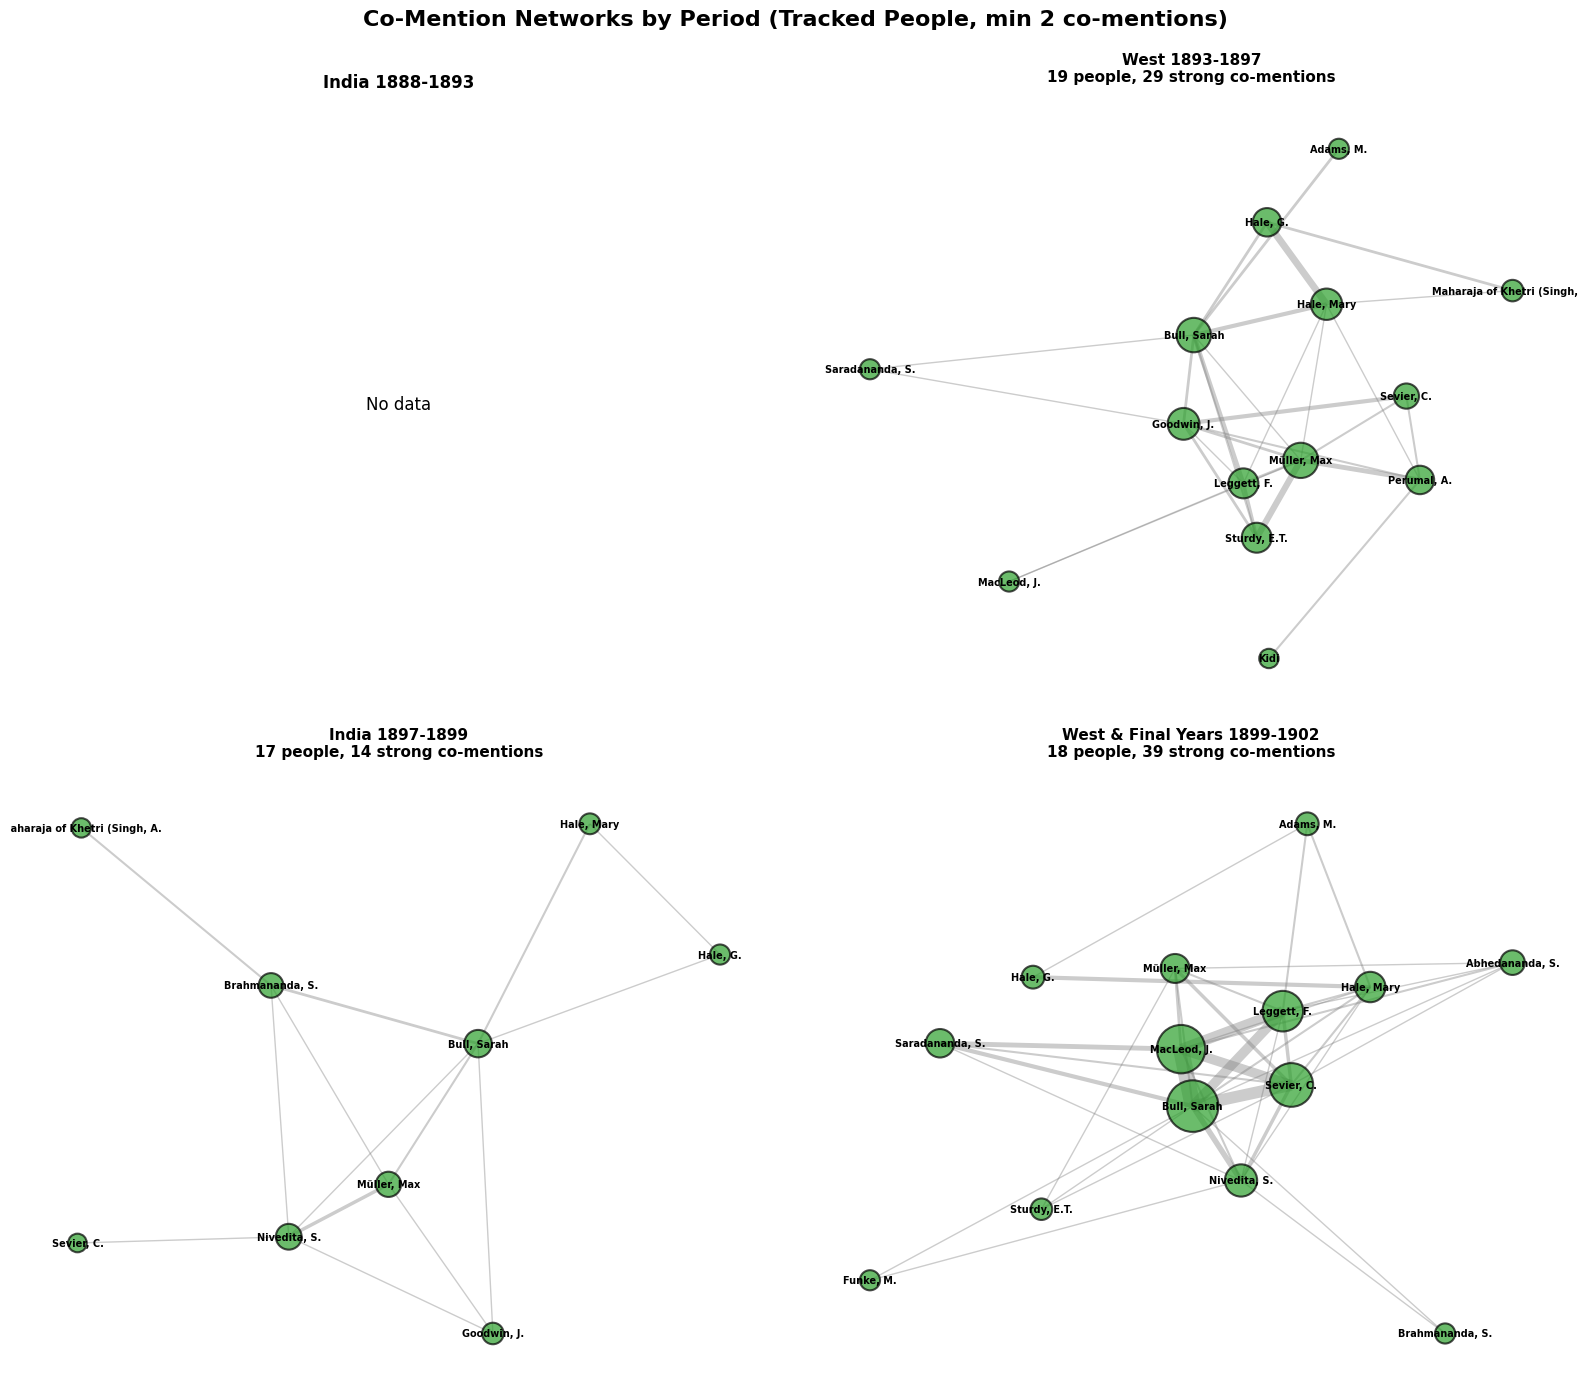

  ✓ Saved: comention_networks_corrected_final.png

[VIZ 2/3] Co-mention heatmap...


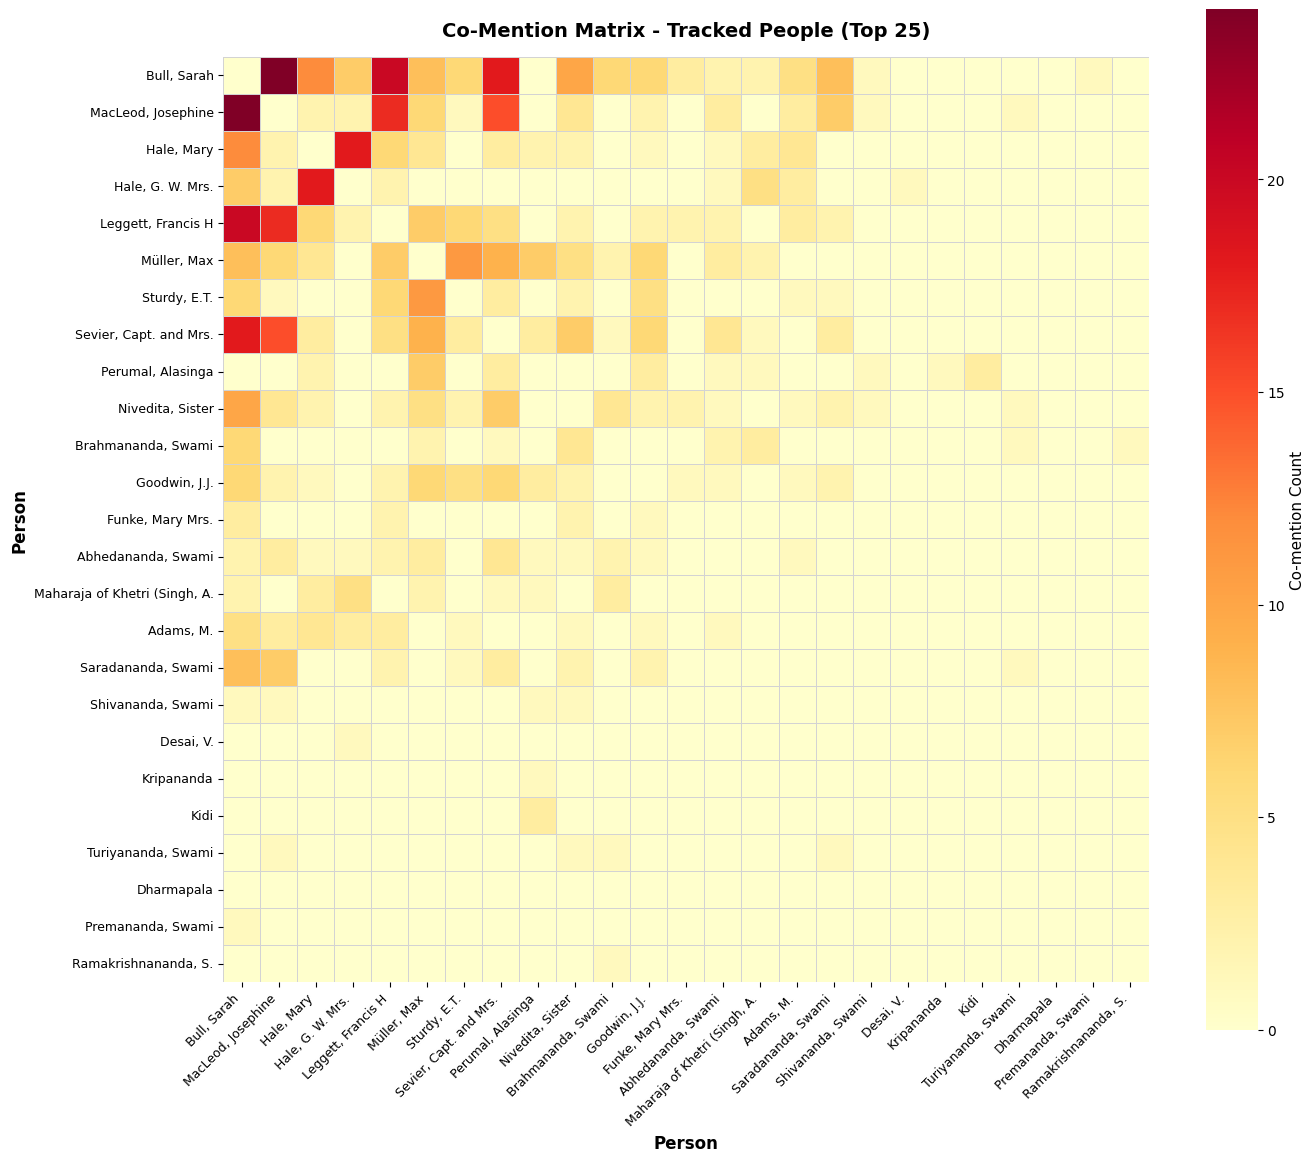

  ✓ Saved: comention_heatmap_corrected_final.png

[VIZ 3/3] Top co-mention pairs...


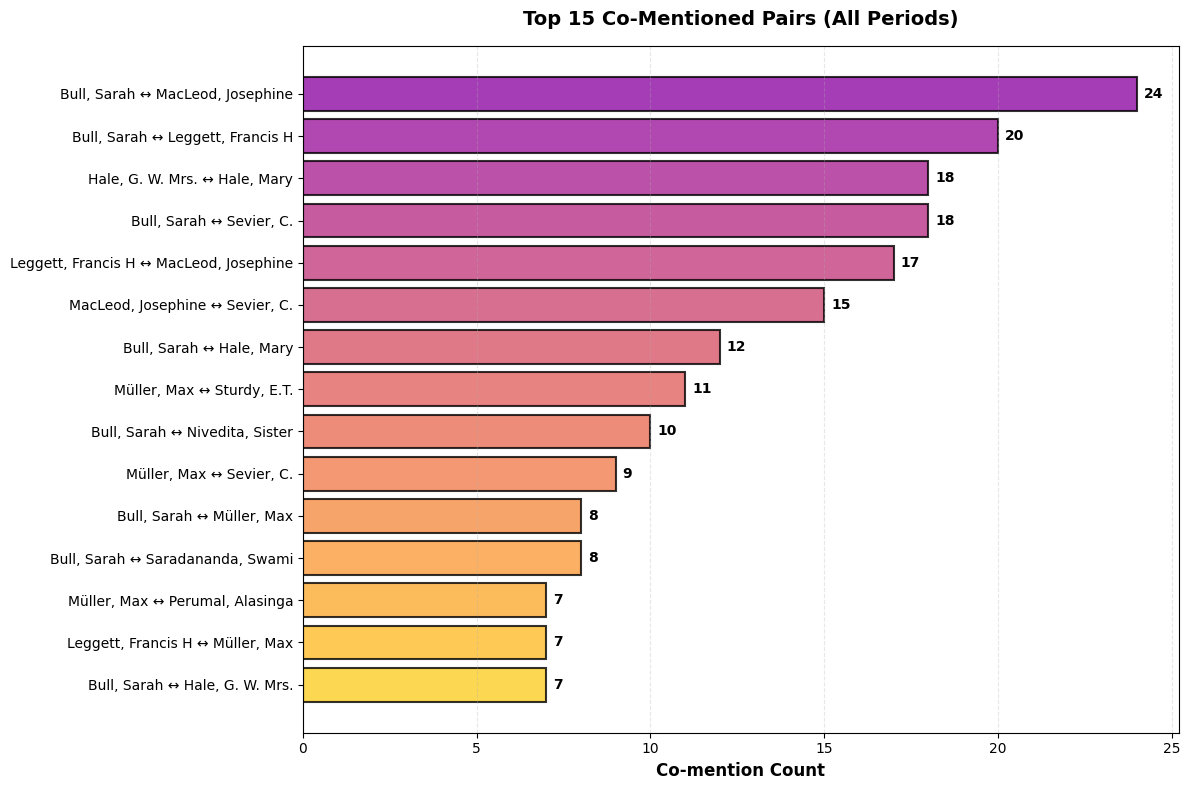

  ✓ Saved: top_comention_pairs_corrected_final.png

CORRECTED CO-MENTION ANALYSIS COMPLETE
✓ Expanded nickname mapping: 107 mappings
✓ Tracked people: 114 (recipients + important non-recipients)
✓ Mentions analyzed: 885
✓ Isolated nodes removed from visualizations
✓ Only showing edges with ≥2 co-mentions

Top co-mentioned pair: Bull, Sarah ↔ MacLeod, Josephine (24 times)

Generated files:
  1. comention_networks_corrected_final.png
  2. comention_heatmap_corrected_final.png
  3. top_comention_pairs_corrected_final.png


In [19]:
# ============================================================================
# CORRECTED CO-MENTION NETWORKS - COMPLETE VERSION
# Expanded nickname mapping + Recipients only + Remove isolated nodes
# ============================================================================

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("CORRECTED CO-MENTION NETWORKS - COMPLETE VERSION")
print("="*80)

# ============================================================================
# STEP 1: EXPANDED NICKNAME MAPPING
# ============================================================================
print("\n[STEP 1] Applying expanded nickname mapping...")

# Comprehensive nickname mapping with newly discovered mappings
nickname_mapping_expanded = {
    # Western correspondents - formal names
    'Bull': 'Bull, Sarah',
    'Ole Bull': 'Bull, Sarah',
    'Sarah Bull': 'Bull, Sarah',

    'Joe': 'MacLeod, Josephine',
    'JOE': 'MacLeod, Josephine',
    'Josephine': 'MacLeod, Josephine',
    'Jo': 'MacLeod, Josephine',

    'G. W. Hale': 'Hale, G. W. Mrs.',
    'Mrs. Hale': 'Hale, G. W. Mrs.',
    'Mrs Hale': 'Hale, G. W. Mrs.',
    'Harriet': 'Hale, G. W. Mrs.',

    'Mary': 'Hale, Mary',
    'Mary Hale': 'Hale, Mary',

    'Christine': 'Christine, Sister',
    'Sister Christine': 'Christine, Sister',

    # Sister Nivedita - Multiple mappings
    'Nivedita': 'Nivedita, Sister',
    'Sister Nivedita': 'Nivedita, Sister',
    'Margaret Noble': 'Nivedita, Sister',
    'Margaret E. Noble': 'Nivedita, Sister',
    'Noble': 'Nivedita, Sister',
    'MARGOT': 'Nivedita, Sister',
    'Miss Noble': 'Nivedita, Sister',

    'ALASINGA': 'Perumal, Alasinga',
    'Alasinga': 'Perumal, Alasinga',
    'Alasinga Perumal': 'Perumal, Alasinga',

    'E. T. Sturdy': 'Sturdy, E.T.',
    'Sturdy': 'Sturdy, E.T.',
    'E.T. Sturdy': 'Sturdy, E.T.',

    'Dewanji': 'Desai, Viaharidas Haridas',
    'Diwanji': 'Desai, Viaharidas Haridas',
    'Dewan': 'Desai, Viaharidas Haridas',
    'Diwan': 'Desai, Viaharidas Haridas',
    'Haridas Desai': 'Desai, Viaharidas Haridas',
    'Haridas': 'Desai, Viaharidas Haridas',
    'Biharidas': 'Desai, Viaharidas Haridas',

    'Khetri': 'Maharaja of Khetri (Singh, Ajit)',
    'Ajit Singh': 'Maharaja of Khetri (Singh, Ajit)',
    'Maharaja': 'Maharaja of Khetri (Singh, Ajit)',

    'Goodwin': 'Goodwin, J.J.',
    'J.J. Goodwin': 'Goodwin, J.J.',

    'Leggett': 'Leggett, Francis H',
    'Francis Leggett': 'Leggett, Francis H',

    # NEW MAPPINGS - Seviers
    'Sevier': 'Sevier, Capt. and Mrs.',
    'Seviers': 'Sevier, Capt. and Mrs.',
    'Captain Sevier': 'Sevier, Capt. and Mrs.',
    'Mrs. Sevier': 'Sevier, Capt. and Mrs.',
    'Charlotte Sevier': 'Sevier, Capt. and Mrs.',
    'James Sevier': 'Sevier, Capt. and Mrs.',

    # NEW MAPPINGS - Max Müller
    'Müller': 'Müller, Max',
    'Max Müller': 'Müller, Max',
    'Professor Müller': 'Müller, Max',
    'Miss Müller': 'Müller, Max',  # Could be related

    # NEW MAPPINGS - Funke
    'Funkey': 'Funke, Mary Mrs.',
    'Funke': 'Funke, Mary Mrs.',
    'Mrs. Funke': 'Funke, Mary Mrs.',
    'Mary Funke': 'Funke, Mary Mrs.',

    # NEW MAPPINGS - Adams
    'Adams': 'Adams, Milward Mr. and Mrs.',
    'Mr. Adams': 'Adams, Milward Mr. and Mrs.',
    'Mrs. Adams': 'Adams, Milward Mr. and Mrs.',
    'Milward Adams': 'Adams, Milward Mr. and Mrs.',

    # NEW MAPPINGS - Other discovered
    'Bagley': 'Bagley',  # Keep as is if no full name known
    'Palmer': 'Palmer',  # Keep as is
    'Landsberg': 'Landsberg',  # Keep as is
    'Pope': 'Pope',  # Keep as is
    'Karma': 'Karma',  # Keep as is (possibly a concept, not person)

    # Swamis and disciples - pre-monastic names
    'Swami Brahmananda': 'Brahmananda, Swami',
    'Brahmananda': 'Brahmananda, Swami',
    'Rakhal': 'Brahmananda, Swami',
    'Rakhal Maharaj': 'Brahmananda, Swami',

    'Swami Ramakrishnananda': 'Ramakrishnananda, Swami',
    'Ramakrishnananda': 'Ramakrishnananda, Swami',
    'Shashi': 'Ramakrishnananda, Swami',

    'Swami Akhandananda': 'Akhandananda, Swami',
    'Akhandananda': 'Akhandananda, Swami',
    'Gangadhar': 'Akhandananda, Swami',

    'Swami Turiyananda': 'Turiyananda, Swami',
    'Turiyananda': 'Turiyananda, Swami',
    'Hari': 'Turiyananda, Swami',
    'Hari Maharaj': 'Turiyananda, Swami',

    'Swami Shivananda': 'Shivananda, Swami',
    'Shivananda': 'Shivananda, Swami',
    'Tarak': 'Shivananda, Swami',

    'Swami Premananda': 'Premananda, Swami',
    'Premananda': 'Premananda, Swami',
    'Baburam': 'Premananda, Swami',

    'Swami Saradananda': 'Saradananda, Swami',
    'Saradananda': 'Saradananda, Swami',
    'Sharat': 'Saradananda, Swami',

    'Swami Abhedananda': 'Abhedananda, Swami',
    'Abhedananda': 'Abhedananda, Swami',
    'Kali': 'Abhedananda, Swami',
    'Kali Maharaj': 'Abhedananda, Swami',

    'Swami Advaitananda': 'Advaitananda, Swami',
    'Advaitananda': 'Advaitananda, Swami',
    'Gopal': 'Advaitananda, Swami',

    'Swami Niranjanananda': 'Niranjanananda, Swami',
    'Niranjanananda': 'Niranjanananda, Swami',
    'Niranjan': 'Niranjanananda, Swami',

    'Swami Trigunatitananda': 'Trigunatitananda, Swami',
    'Trigunatitananda': 'Trigunatitananda, Swami',
    'Sarada': 'Trigunatitananda, Swami',

    # Holy Mother and Master
    'Sri Ramakrishna': 'Ramakrishna, Sri',
    'Ramakrishna': 'Ramakrishna, Sri',
    'Master': 'Ramakrishna, Sri',
    'The Master': 'Ramakrishna, Sri',

    'Holy Mother': 'Sarada Devi, Sri',
    'Sri Sarada Devi': 'Sarada Devi, Sri',
}

# Re-apply mapping to mentions
mentions_df['resolved_name'] = mentions_df['name'].replace(nickname_mapping_expanded)
resolved_mentions_df = mentions_df.copy()

print(f"  Applied {len(nickname_mapping_expanded)} nickname mappings")
print(f"  Total mentions: {len(resolved_mentions_df)}")
print(f"  Unique resolved names: {resolved_mentions_df['resolved_name'].nunique()}")

# ============================================================================
# STEP 2: FILTER TO RECIPIENTS AND IMPORTANT PEOPLE
# ============================================================================
print("\n[STEP 2] Filtering to recipients and important people...")

# Get all recipients from audience_clean
all_recipients = set(all_letters['Audience_clean'].dropna().unique())

# Add important people who should be tracked even if not primary recipients
# (e.g., Seviers, Max Müller, Funke, Adams who appear in our mapping)
important_non_recipients = {
    'Sevier, Capt. and Mrs.',
    'Müller, Max',
    'Funke, Mary Mrs.',
    'Adams, Milward Mr. and Mrs.',
}

# Combine recipients with important non-recipients
people_to_track = all_recipients | important_non_recipients

print(f"  Recipients: {len(all_recipients)}")
print(f"  Important non-recipients added: {len(important_non_recipients)}")
print(f"  Total people to track: {len(people_to_track)}")

# Filter mentions
recipient_mentions_df = resolved_mentions_df[
    resolved_mentions_df['resolved_name'].isin(people_to_track)
].copy()

print(f"  Mentions of tracked people: {len(recipient_mentions_df)}")
print(f"  Unique people mentioned: {recipient_mentions_df['resolved_name'].nunique()}")

# Show excluded
excluded_count = len(resolved_mentions_df) - len(recipient_mentions_df)
if excluded_count > 0:
    excluded_names = resolved_mentions_df[
        ~resolved_mentions_df['resolved_name'].isin(people_to_track)
    ]['resolved_name'].value_counts().head(10)

    print(f"\n  Top 10 excluded (non-tracked) names:")
    for name, count in excluded_names.items():
        print(f"    - {name}: {count} mentions")

# ============================================================================
# STEP 3: BUILD CORRECTED CO-MENTION NETWORKS BY PERIOD
# ============================================================================
print("\n[STEP 3] Building co-mention networks (tracked people only)...")

comention_networks_corrected = {}

for period in sorted(all_letters['period'].unique()):
    if period == 'Unknown':
        continue

    period_mentions = recipient_mentions_df[recipient_mentions_df['period'] == period]

    G = nx.Graph()
    comention_counts = defaultdict(int)

    for letter_id in period_mentions['letter_id'].unique():
        letter_mentions = period_mentions[period_mentions['letter_id'] == letter_id]
        mentioned_people = letter_mentions['resolved_name'].unique()

        for i, person1 in enumerate(mentioned_people):
            for person2 in mentioned_people[i+1:]:
                pair = tuple(sorted([person1, person2]))
                comention_counts[pair] += 1

    for (person1, person2), weight in comention_counts.items():
        G.add_edge(person1, person2, weight=weight)

    # Remove isolated nodes (nodes with no edges)
    isolated_nodes = list(nx.isolates(G))
    G.remove_nodes_from(isolated_nodes)

    comention_networks_corrected[period] = G
    print(f"  {period}: {G.number_of_nodes()} people, {G.number_of_edges()} co-mention edges")

# ============================================================================
# STEP 4: BUILD OVERALL CO-MENTION MATRIX
# ============================================================================
print("\n[STEP 4] Building overall co-mention matrix...")

top_mentioned_recipients = recipient_mentions_df['resolved_name'].value_counts().head(25).index.tolist()

comention_matrix_corrected = pd.DataFrame(0, index=top_mentioned_recipients, columns=top_mentioned_recipients)

for letter_id in recipient_mentions_df['letter_id'].unique():
    letter_mentions = recipient_mentions_df[recipient_mentions_df['letter_id'] == letter_id]
    mentioned = letter_mentions['resolved_name'].unique()

    for person1 in mentioned:
        if person1 in top_mentioned_recipients:
            for person2 in mentioned:
                if person2 in top_mentioned_recipients and person1 != person2:
                    comention_matrix_corrected.loc[person1, person2] += 1

print(f"  Built {len(top_mentioned_recipients)}x{len(top_mentioned_recipients)} matrix")

# ============================================================================
# STEP 5: STATISTICS
# ============================================================================
print("\n[STEP 5] Top mentioned tracked people:")

top_15 = recipient_mentions_df['resolved_name'].value_counts().head(15)
for rank, (name, count) in enumerate(top_15.items(), 1):
    print(f"  {rank:2d}. {name:<40} {count:4d} mentions")

# ============================================================================
# VISUALIZATIONS
# ============================================================================
print("\n" + "="*80)
print("CREATING VISUALIZATIONS")
print("="*80)

def abbreviate_name(name, max_length=20):
    if len(name) <= max_length:
        return name
    parts = name.split(',')
    if len(parts) >= 2:
        return f"{parts[0]}, {parts[1].strip()[0]}."
    return name[:max_length-3] + "..."

plt.rcParams['font.size'] = 10
plt.rcParams['figure.dpi'] = 100

period_labels = {
    'Period1_India_1888-1893': 'India 1888-1893',
    'Period2_West_1893-1897': 'West 1893-1897',
    'Period3_India_1897-1899': 'India 1897-1899',
    'Period4_West_Final_1899-1902': 'West & Final Years 1899-1902'
}

# VIZ 1: Co-mention Networks by Period
print("\n[VIZ 1/3] Co-mention networks by period...")

fig, axes = plt.subplots(2, 2, figsize=(16, 14))
fig.suptitle('Co-Mention Networks by Period (Tracked People, min 2 co-mentions)',
             fontsize=16, fontweight='bold', y=0.995)

periods = sorted([p for p in comention_networks_corrected.keys()])
axes_flat = axes.flatten()

for idx, period in enumerate(periods):
    ax = axes_flat[idx]
    G = comention_networks_corrected[period]

    if G.number_of_nodes() > 1 and G.number_of_edges() > 0:
        # Filter edges by weight >= 2
        edges_filtered = [(u, v) for u, v in G.edges() if G[u][v]['weight'] >= 2]

        if len(edges_filtered) > 0:
            # Create subgraph with only strong edges
            G_filtered = nx.Graph()
            for u, v in edges_filtered:
                G_filtered.add_edge(u, v, weight=G[u][v]['weight'])

            # Take top 15 nodes by degree
            degrees = dict(G_filtered.degree(weight='weight'))
            if len(degrees) > 15:
                top_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:15]
                top_node_names = [node for node, deg in top_nodes]
                G_sub = G_filtered.subgraph(top_node_names).copy()
            else:
                G_sub = G_filtered

            if G_sub.number_of_nodes() > 0:
                pos = nx.spring_layout(G_sub, k=1.5, iterations=50, seed=42)

                node_sizes = [150 + degrees.get(node, 0) * 15 for node in G_sub.nodes()]
                edge_widths = [G_sub[u][v]['weight'] * 0.5 for u, v in G_sub.edges()]

                nx.draw_networkx_edges(G_sub, pos, ax=ax, width=edge_widths,
                                     alpha=0.4, edge_color='gray')
                nx.draw_networkx_nodes(G_sub, pos, ax=ax, node_size=node_sizes,
                                     node_color='#2ca02c', alpha=0.7,
                                     edgecolors='black', linewidths=1.5)

                labels = {node: abbreviate_name(node, 12) for node in G_sub.nodes()}
                nx.draw_networkx_labels(G_sub, pos, labels, ax=ax, font_size=7,
                                       font_weight='bold')

                n_total_nodes = G.number_of_nodes()
                n_strong_edges = len(edges_filtered)
                ax.set_title(f"{period_labels[period]}\n{n_total_nodes} people, {n_strong_edges} strong co-mentions",
                           fontsize=11, fontweight='bold', pad=10)
            else:
                ax.text(0.5, 0.5, 'No strong co-mentions', ha='center', va='center', fontsize=12)
                ax.set_title(period_labels[period], fontsize=12, fontweight='bold')
        else:
            ax.text(0.5, 0.5, 'No strong co-mentions', ha='center', va='center', fontsize=12)
            ax.set_title(period_labels[period], fontsize=12, fontweight='bold')
    else:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center', fontsize=12)
        ax.set_title(period_labels[period], fontsize=12, fontweight='bold')

    ax.axis('off')

plt.tight_layout()
plt.savefig('comention_networks_corrected_final.png', dpi=150, bbox_inches='tight')
plt.show()
print("  ✓ Saved: comention_networks_corrected_final.png")

# VIZ 2: Co-mention Heatmap
print("\n[VIZ 2/3] Co-mention heatmap...")

fig, ax = plt.subplots(figsize=(14, 12))

abbrev_names = [abbreviate_name(name, 22) for name in comention_matrix_corrected.index]

sns.heatmap(comention_matrix_corrected,
            xticklabels=abbrev_names,
            yticklabels=abbrev_names,
            cmap='YlOrRd',
            annot=False,
            cbar_kws={'label': 'Co-mention Count'},
            linewidths=0.5,
            linecolor='lightgray',
            square=True,
            ax=ax)

ax.set_title('Co-Mention Matrix - Tracked People (Top 25)',
            fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('Person', fontsize=12, fontweight='bold')
ax.set_ylabel('Person', fontsize=12, fontweight='bold')

plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)

plt.tight_layout()
plt.savefig('comention_heatmap_corrected_final.png', dpi=150, bbox_inches='tight')
plt.show()
print("  ✓ Saved: comention_heatmap_corrected_final.png")

# VIZ 3: Top Co-mention Pairs
print("\n[VIZ 3/3] Top co-mention pairs...")

all_pairs = []
for period, G in comention_networks_corrected.items():
    for u, v in G.edges():
        weight = G[u][v]['weight']
        all_pairs.append({'person1': u, 'person2': v, 'weight': weight, 'period': period})

pairs_df = pd.DataFrame(all_pairs)

pair_totals = {}
for _, row in pairs_df.iterrows():
    pair = tuple(sorted([row['person1'], row['person2']]))
    if pair not in pair_totals:
        pair_totals[pair] = 0
    pair_totals[pair] += row['weight']

top_pairs = sorted(pair_totals.items(), key=lambda x: x[1], reverse=True)[:15]

fig, ax = plt.subplots(figsize=(12, 8))

pair_labels = [f"{abbreviate_name(p1, 18)} ↔ {abbreviate_name(p2, 18)}"
               for (p1, p2), _ in top_pairs]
pair_values = [count for _, count in top_pairs]

y_pos = np.arange(len(pair_labels))
colors = plt.cm.plasma(np.linspace(0.3, 0.9, len(pair_labels)))

ax.barh(y_pos, pair_values, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

ax.set_yticks(y_pos)
ax.set_yticklabels(pair_labels, fontsize=10)
ax.invert_yaxis()

for i, v in enumerate(pair_values):
    ax.text(v + 0.2, i, str(v), va='center', fontsize=10, fontweight='bold')

ax.set_xlabel('Co-mention Count', fontsize=12, fontweight='bold')
ax.set_title('Top 15 Co-Mentioned Pairs (All Periods)', fontsize=14, fontweight='bold', pad=15)
ax.grid(axis='x', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('top_comention_pairs_corrected_final.png', dpi=150, bbox_inches='tight')
plt.show()
print("  ✓ Saved: top_comention_pairs_corrected_final.png")

# ============================================================================
# SUMMARY
# ============================================================================
print("\n" + "="*80)
print("CORRECTED CO-MENTION ANALYSIS COMPLETE")
print("="*80)
print(f"✓ Expanded nickname mapping: {len(nickname_mapping_expanded)} mappings")
print(f"✓ Tracked people: {len(people_to_track)} (recipients + important non-recipients)")
print(f"✓ Mentions analyzed: {len(recipient_mentions_df)}")
print(f"✓ Isolated nodes removed from visualizations")
print(f"✓ Only showing edges with ≥2 co-mentions")
print(f"\nTop co-mentioned pair: {top_pairs[0][0][0]} ↔ {top_pairs[0][0][1]} ({top_pairs[0][1]} times)")
print("\nGenerated files:")
print("  1. comention_networks_corrected_final.png")
print("  2. comention_heatmap_corrected_final.png")
print("  3. top_comention_pairs_corrected_final.png")
print("="*80)

# Update global variables
comention_networks = comention_networks_corrected
comention_matrix = comention_matrix_corrected
nickname_mapping = nickname_mapping_expanded

PART 1: DIAGNOSTIC ANALYSIS - MISSING CO-MENTIONS

[DIAGNOSTIC 1] Investigating Period 1 (1888-1893) co-mentions...
Total letters in Period 1: 60
Letters mentioning 'Mitra' in audience: 32
Recipients:
  - Mitra, Pramadadas: 32 letters

All Mitra variants in recipients: ['Mitra, Indumati', 'Mitra, Haripada', 'Mitra, Pramadadas']

Mentions in Period 1: 1
Unique people mentioned: 1
Top 10 mentioned:
  - Desai, Viaharidas Haridas: 1

Raw 'Shashi' mentions in Period 1: 0

Raw 'Babaji' mentions in Period 1: 0

[DIAGNOSTIC 2] Investigating Margaret Noble in Period 2 (1893-1897)...

Total letters to Nivedita: 48
Distribution by period:
  - Period4_West_Final_1899-1902: 31
  - Period3_India_1897-1899: 13
  - Period2_West_1893-1897: 4

Date range: 1895/10/04 to 1902/02/12

Mentions of Noble/Nivedita/Margaret in Period 2: 1
Name variants found:
  - 'Miss M. Noble': 1

Resolved names:
  - 'Miss M. Noble': 1

Is 'Nivedita, Sister' in tracked people? True
Is 'Nivedita, Sister' in recipients? True

P

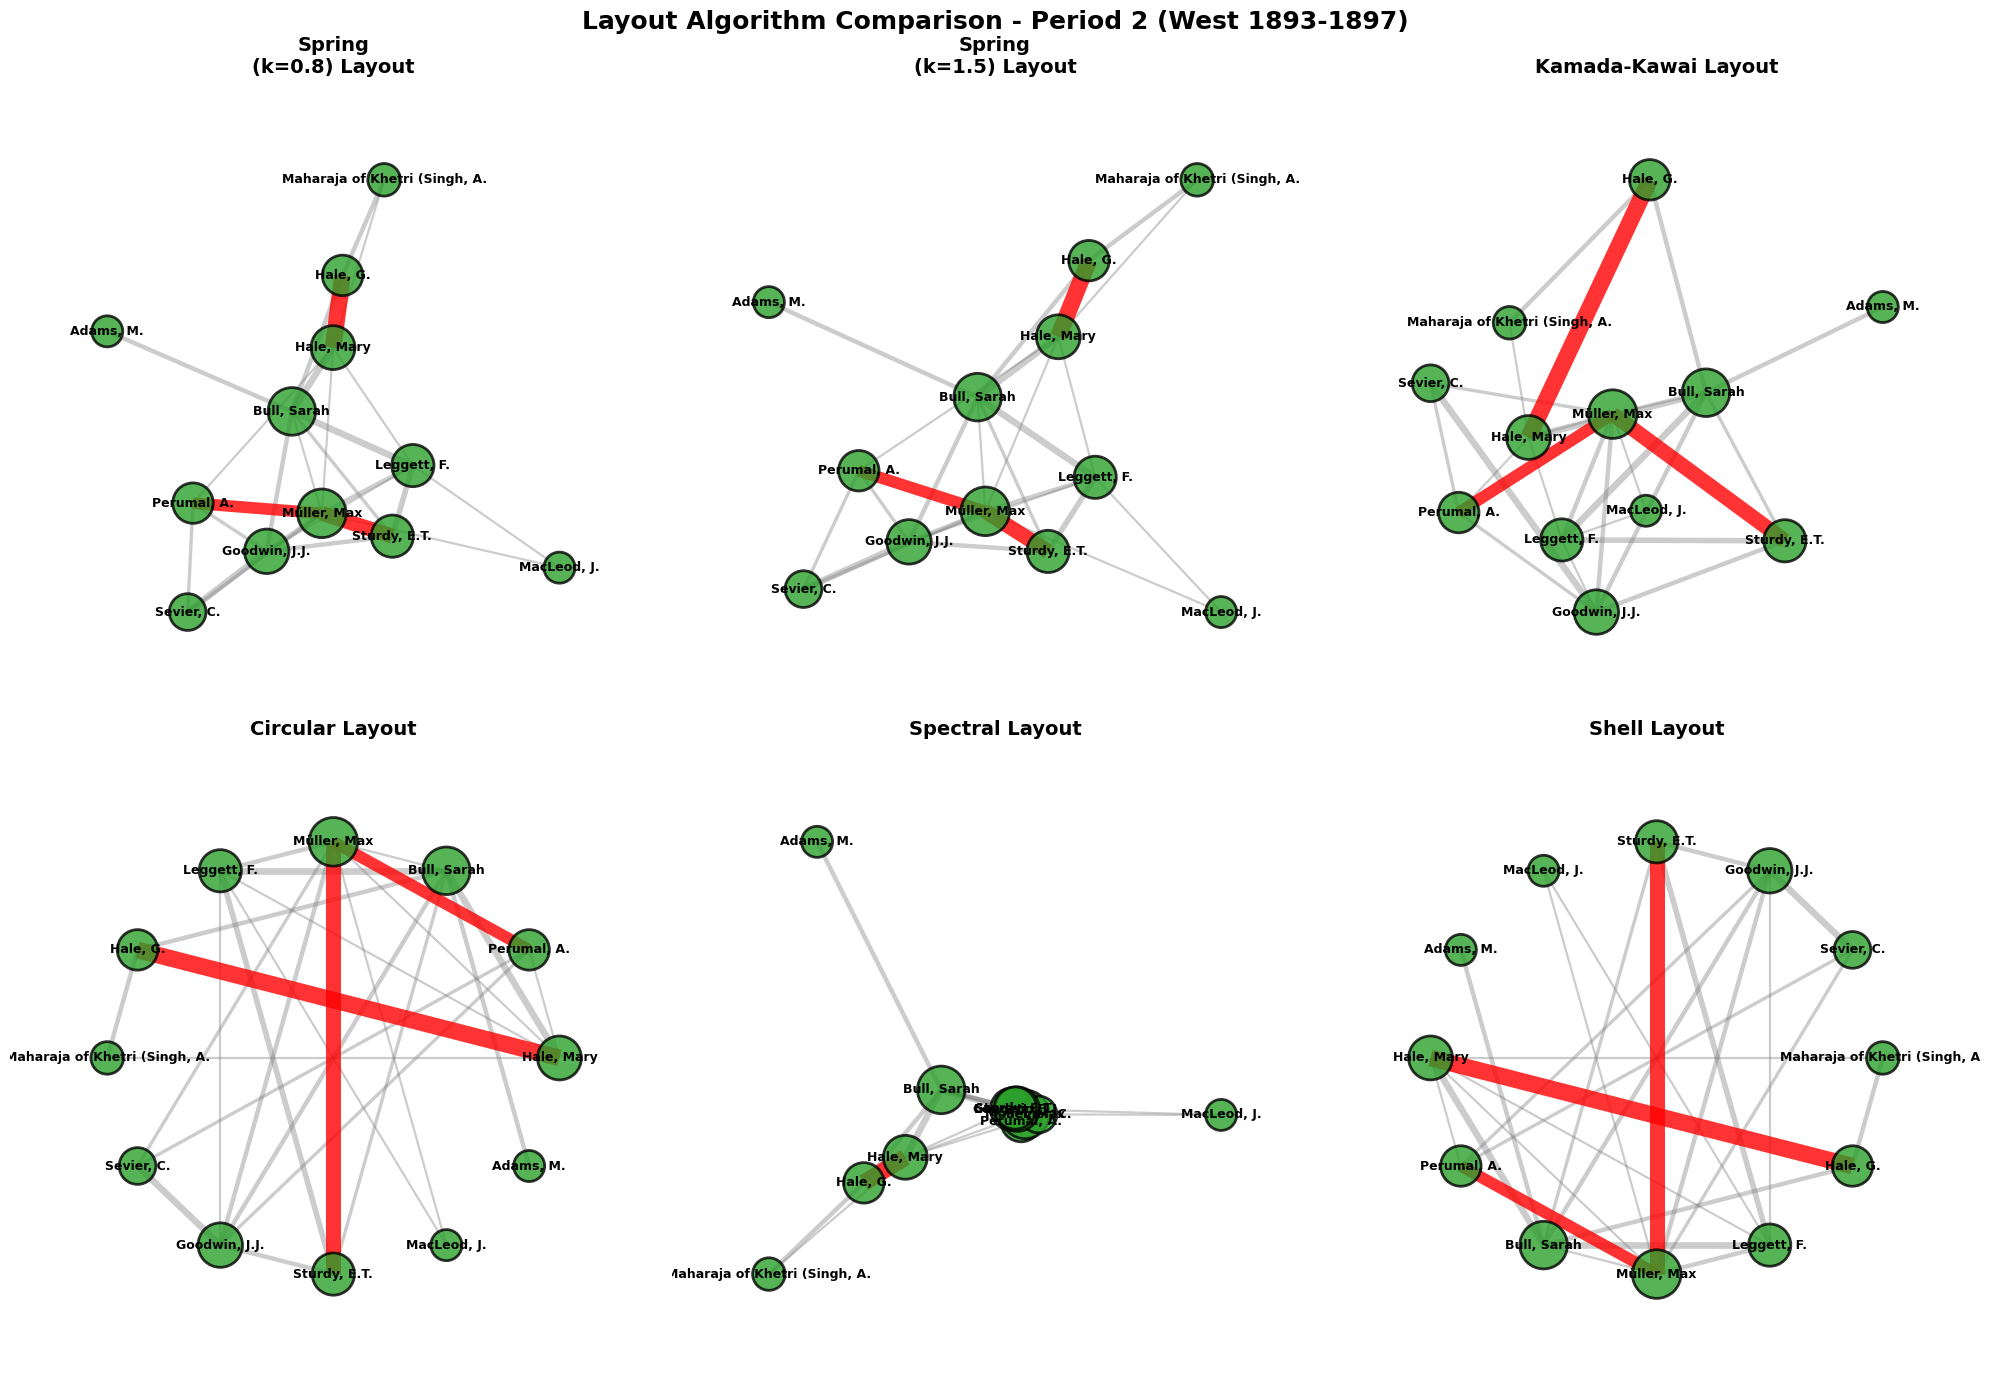


✓ Saved: layout_comparison_period2.png

DIAGNOSTIC SUMMARY

Possible issues:
1. Pramadadas Mitra may not be in audience_clean (check spelling)
2. Babaji may not be mapped to a recipient
3. Period 1 letters might not have body_text for NER
4. Margaret Noble might have been mentioned BEFORE she was a recipient
   (She only received letters in later periods)

Recommendations:
- Check if 'Mitra, Pramadadas' is exact spelling in audience_clean
- Add 'Babaji' mappings to nickname_mapping
- Verify Period 1 letters have body_text for NER extraction


In [20]:
# ============================================================================
# LAYOUT ALGORITHM COMPARISON + DIAGNOSTIC ANALYSIS
# ============================================================================

import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("PART 1: DIAGNOSTIC ANALYSIS - MISSING CO-MENTIONS")
print("="*80)

# ============================================================================
# DIAGNOSTIC 1: Why no co-mentions in Period 1 (1888-1893)?
# ============================================================================
print("\n[DIAGNOSTIC 1] Investigating Period 1 (1888-1893) co-mentions...")

period1_letters = all_letters[all_letters['period'] == 'Period1_India_1888-1893']
print(f"Total letters in Period 1: {len(period1_letters)}")

# Check letters to Pramadadas Mitra
pramadadas_letters = period1_letters[period1_letters['Audience_clean'].str.contains('Mitra', na=False, case=False)]
print(f"Letters mentioning 'Mitra' in audience: {len(pramadadas_letters)}")
if len(pramadadas_letters) > 0:
    print(f"Recipients:")
    for name in pramadadas_letters['Audience_clean'].unique():
        count = len(pramadadas_letters[pramadadas_letters['Audience_clean'] == name])
        print(f"  - {name}: {count} letters")

# Check if Pramadadas is in our tracked people
all_recipients = set(all_letters['Audience_clean'].dropna().unique())
mitra_variants = [r for r in all_recipients if 'mitra' in r.lower()]
print(f"\nAll Mitra variants in recipients: {mitra_variants}")

# Check mentions in Period 1
period1_mentions = recipient_mentions_df[recipient_mentions_df['period'] == 'Period1_India_1888-1893']
print(f"\nMentions in Period 1: {len(period1_mentions)}")
print(f"Unique people mentioned: {period1_mentions['resolved_name'].nunique()}")
if len(period1_mentions) > 0:
    print(f"Top 10 mentioned:")
    for name, count in period1_mentions['resolved_name'].value_counts().head(10).items():
        print(f"  - {name}: {count}")

# Check for Shashi mentions
shashi_mentions = mentions_df[
    (mentions_df['period'] == 'Period1_India_1888-1893') &
    (mentions_df['name'].str.contains('Shashi', na=False, case=False))
]
print(f"\nRaw 'Shashi' mentions in Period 1: {len(shashi_mentions)}")
if len(shashi_mentions) > 0:
    print("Sample Shashi mentions:")
    print(shashi_mentions[['name', 'recipient']].head())

# Check for Babaji
babaji_mentions = mentions_df[
    (mentions_df['period'] == 'Period1_India_1888-1893') &
    (mentions_df['name'].str.contains('Babaji', na=False, case=False))
]
print(f"\nRaw 'Babaji' mentions in Period 1: {len(babaji_mentions)}")
if len(babaji_mentions) > 0:
    print("Babaji mentions:")
    print(babaji_mentions[['name', 'recipient']].value_counts())

# ============================================================================
# DIAGNOSTIC 2: Why no Margaret Noble in Period 2 (1893-1897)?
# ============================================================================
print("\n" + "="*80)
print("[DIAGNOSTIC 2] Investigating Margaret Noble in Period 2 (1893-1897)...")
print("="*80)

# Check when Nivedita received letters
nivedita_letters = all_letters[all_letters['Audience_clean'] == 'Nivedita, Sister']
print(f"\nTotal letters to Nivedita: {len(nivedita_letters)}")
if len(nivedita_letters) > 0:
    print("Distribution by period:")
    for period, count in nivedita_letters['period'].value_counts().items():
        print(f"  - {period}: {count}")
    print(f"\nDate range: {nivedita_letters['Date'].min()} to {nivedita_letters['Date'].max()}")

# Check mentions of Margaret Noble / Nivedita in Period 2
period2_mentions = mentions_df[mentions_df['period'] == 'Period2_West_1893-1897']
noble_mentions = period2_mentions[
    period2_mentions['name'].str.contains('Noble|Nivedita|Margaret', na=False, case=False)
]
print(f"\nMentions of Noble/Nivedita/Margaret in Period 2: {len(noble_mentions)}")
if len(noble_mentions) > 0:
    print("Name variants found:")
    for name, count in noble_mentions['name'].value_counts().items():
        print(f"  - '{name}': {count}")
    print("\nResolved names:")
    for name, count in noble_mentions['resolved_name'].value_counts().items():
        print(f"  - '{name}': {count}")

# Check if Nivedita is in tracked people
important_non_recipients = {
    'Sevier, Capt. and Mrs.',
    'Müller, Max',
    'Funke, Mary Mrs.',
    'Adams, Milward Mr. and Mrs.',
}
people_to_track = all_recipients | important_non_recipients

print(f"\nIs 'Nivedita, Sister' in tracked people? {'Nivedita, Sister' in people_to_track}")
print(f"Is 'Nivedita, Sister' in recipients? {'Nivedita, Sister' in all_recipients}")

# ============================================================================
# PART 2: LAYOUT ALGORITHM COMPARISON
# ============================================================================
print("\n" + "="*80)
print("PART 2: COMPARING LAYOUT ALGORITHMS FOR PERIOD 2 (1893-1897)")
print("="*80)

def abbreviate_name(name, max_length=14):
    if len(name) <= max_length:
        return name
    parts = name.split(',')
    if len(parts) >= 2:
        return f"{parts[0]}, {parts[1].strip()[0]}."
    return name[:max_length-3] + "..."

# Get Period 2 network
period = 'Period2_West_1893-1897'
G = comention_networks_corrected[period]

# Filter edges by weight >= 2
edges_filtered = [(u, v) for u, v in G.edges() if G[u][v]['weight'] >= 2]

if len(edges_filtered) > 0:
    # Create filtered graph
    G_filtered = nx.Graph()
    for u, v in edges_filtered:
        G_filtered.add_edge(u, v, weight=G[u][v]['weight'])

    # Take top 12 nodes by degree (reduced from 15 for clarity)
    degrees = dict(G_filtered.degree(weight='weight'))
    if len(degrees) > 12:
        top_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:12]
        top_node_names = [node for node, deg in top_nodes]
        G_sub = G_filtered.subgraph(top_node_names).copy()
    else:
        G_sub = G_filtered

    print(f"\nNetwork stats: {G_sub.number_of_nodes()} nodes, {G_sub.number_of_edges()} edges")

    # Get node sizes and edge info
    node_sizes = [400 + degrees.get(node, 0) * 25 for node in G_sub.nodes()]

    # Get top 3 edges
    edge_weights = [(u, v, G_sub[u][v]['weight']) for u, v in G_sub.edges()]
    edge_weights_sorted = sorted(edge_weights, key=lambda x: x[2], reverse=True)
    top_3_edges = set([(u, v) for u, v, w in edge_weights_sorted[:3]])

    # Create figure with 6 subplots (2 rows x 3 columns)
    fig, axes = plt.subplots(2, 3, figsize=(20, 14))
    fig.suptitle('Layout Algorithm Comparison - Period 2 (West 1893-1897)',
                 fontsize=18, fontweight='bold')

    layouts = {
        'Spring\n(k=0.8)': nx.spring_layout(G_sub, k=0.8, iterations=80, seed=42),
        'Spring\n(k=1.5)': nx.spring_layout(G_sub, k=1.5, iterations=80, seed=42),
        'Kamada-Kawai': nx.kamada_kawai_layout(G_sub),
        'Circular': nx.circular_layout(G_sub),
        'Spectral': nx.spectral_layout(G_sub),
        'Shell': nx.shell_layout(G_sub),
    }

    for idx, (layout_name, pos) in enumerate(layouts.items()):
        row = idx // 3
        col = idx % 3
        ax = axes[row, col]

        # Draw regular edges
        regular_edges = [(u, v) for u, v in G_sub.edges()
                        if (u, v) not in top_3_edges and (v, u) not in top_3_edges]
        regular_widths = [G_sub[u][v]['weight'] * 0.8 for u, v in regular_edges]

        if len(regular_edges) > 0:
            nx.draw_networkx_edges(G_sub, pos, ax=ax, edgelist=regular_edges,
                                 width=regular_widths, alpha=0.4, edge_color='gray')

        # Draw top 3 edges in red
        top_3_edges_list = [(u, v) for u, v in G_sub.edges()
                           if (u, v) in top_3_edges or (v, u) in top_3_edges]
        top_3_widths = [G_sub[u][v]['weight'] * 1.2 for u, v in top_3_edges_list]

        if len(top_3_edges_list) > 0:
            nx.draw_networkx_edges(G_sub, pos, ax=ax, edgelist=top_3_edges_list,
                                 width=top_3_widths, alpha=0.8, edge_color='red')

        # Draw nodes
        nx.draw_networkx_nodes(G_sub, pos, ax=ax, node_size=node_sizes,
                             node_color='#2ca02c', alpha=0.8,
                             edgecolors='black', linewidths=2)

        # Draw labels
        labels = {node: abbreviate_name(node, 14) for node in G_sub.nodes()}
        nx.draw_networkx_labels(G_sub, pos, labels, ax=ax, font_size=9,
                               font_weight='bold', font_color='black')

        ax.set_title(f'{layout_name} Layout', fontsize=14, fontweight='bold', pad=10)
        ax.axis('off')
        ax.margins(0.15)

    plt.tight_layout()
    plt.savefig('layout_comparison_period2.png', dpi=200, bbox_inches='tight')
    plt.show()

    print("\n✓ Saved: layout_comparison_period2.png")
else:
    print("\nNo edges to visualize for Period 2")

# ============================================================================
# SUMMARY
# ============================================================================
print("\n" + "="*80)
print("DIAGNOSTIC SUMMARY")
print("="*80)
print("\nPossible issues:")
print("1. Pramadadas Mitra may not be in audience_clean (check spelling)")
print("2. Babaji may not be mapped to a recipient")
print("3. Period 1 letters might not have body_text for NER")
print("4. Margaret Noble might have been mentioned BEFORE she was a recipient")
print("   (She only received letters in later periods)")
print("\nRecommendations:")
print("- Check if 'Mitra, Pramadadas' is exact spelling in audience_clean")
print("- Add 'Babaji' mappings to nickname_mapping")
print("- Verify Period 1 letters have body_text for NER extraction")
print("="*80)

In [21]:
# ============================================================================
# DIRECT VERIFICATION AND COMPLETE PERIOD 1 NER ANALYSIS
# ============================================================================

import pandas as pd
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("DIRECT VERIFICATION FROM CSV")
print("="*80)

# ============================================================================
# PART 1: VERIFY NIVEDITA LETTERS DIRECTLY FROM CSV
# ============================================================================
print("\n[1] Checking Nivedita letters directly from original CSV...")

# Load fresh from CSV
letters_fresh = pd.read_csv("swami_vivekananda_letters_complete.csv")
print(f"Total letters in CSV: {len(letters_fresh)}")

# Check all audience variations that might be Nivedita
nivedita_variations = letters_fresh[
    letters_fresh['Audience'].str.contains('Nivedita|Noble', na=False, case=False)
]

print(f"\nLetters with 'Nivedita' or 'Noble' in Audience: {len(nivedita_variations)}")
print("\nUnique Audience values:")
for audience in nivedita_variations['Audience'].unique():
    count = len(nivedita_variations[nivedita_variations['Audience'] == audience])
    print(f"  - '{audience}': {count} letters")

# Check dates for these letters
print("\nDate distribution:")
nivedita_variations['year'] = nivedita_variations['Date'].str.extract(r'(\d{4})')[0].astype(float)
print(nivedita_variations['year'].value_counts().sort_index())

# Show specific letters from 1893-1897
period2_nivedita = nivedita_variations[
    (nivedita_variations['year'] >= 1893) &
    (nivedita_variations['year'] < 1897)
]
print(f"\nNivedita letters 1893-1897: {len(period2_nivedita)}")
if len(period2_nivedita) > 0:
    print("Details:")
    for idx, row in period2_nivedita.iterrows():
        print(f"  - Date: {row['Date']}, Audience: '{row['Audience']}'")

# ============================================================================
# PART 2: COMPLETE NER EXTRACTION FOR PERIOD 1
# ============================================================================
print("\n" + "="*80)
print("COMPLETE NER EXTRACTION - PERIOD 1 (1888-1893)")
print("="*80)

# Get Period 1 letters
period1_letters = all_letters[all_letters['period'] == 'Period1_India_1888-1893']
print(f"\nTotal Period 1 letters: {len(period1_letters)}")
print(f"Letters with body_text: {period1_letters['body_text'].notna().sum()}")

# Focus on Pramadadas Mitra letters
mitra_letters = period1_letters[period1_letters['Audience_clean'] == 'Mitra, Pramadadas']
print(f"\nLetters to Pramadadas Mitra: {len(mitra_letters)}")
print(f"Mitra letters with body_text: {mitra_letters['body_text'].notna().sum()}")

# Extract ALL named entities from Mitra letters
print("\n" + "="*80)
print("EXTRACTING ALL NAMED ENTITIES FROM MITRA LETTERS")
print("="*80)

if nlp is not None:
    all_entities_mitra = []

    for idx, row in mitra_letters.iterrows():
        if pd.notna(row['body_text']) and len(str(row['body_text'])) > 10:
            try:
                text = str(row['body_text'])[:50000]
                doc = nlp(text)

                for ent in doc.ents:
                    if ent.label_ == 'PERSON':
                        name = ent.text.strip()
                        if len(name) > 2:
                            all_entities_mitra.append({
                                'name': name,
                                'letter_date': row['Date'],
                                'letter_index': idx,
                                'sentence': ent.sent.text[:100]  # First 100 chars of sentence
                            })
            except:
                continue

    mitra_entities_df = pd.DataFrame(all_entities_mitra)

    if len(mitra_entities_df) > 0:
        print(f"\nTotal named entities extracted from Mitra letters: {len(mitra_entities_df)}")
        print(f"Unique names: {mitra_entities_df['name'].nunique()}")

        print("\n" + "="*80)
        print("ALL UNIQUE NAMES MENTIONED IN MITRA LETTERS (SORTED BY FREQUENCY)")
        print("="*80)

        name_counts = mitra_entities_df['name'].value_counts()
        for rank, (name, count) in enumerate(name_counts.items(), 1):
            print(f"{rank:3d}. '{name}': {count} mentions")

        # Check for specific names
        print("\n" + "="*80)
        print("CHECKING FOR SPECIFIC NAMES")
        print("="*80)

        shashi_variants = mitra_entities_df[
            mitra_entities_df['name'].str.contains('Shashi|Sharat', na=False, case=False)
        ]
        print(f"\nShashi/Sharat mentions: {len(shashi_variants)}")
        if len(shashi_variants) > 0:
            print("Names found:")
            for name in shashi_variants['name'].unique():
                print(f"  - '{name}'")

        babaji_variants = mitra_entities_df[
            mitra_entities_df['name'].str.contains('Babaji|Baba', na=False, case=False)
        ]
        print(f"\nBabaji/Baba mentions: {len(babaji_variants)}")
        if len(babaji_variants) > 0:
            print("Names found:")
            for name in babaji_variants['name'].unique():
                count = len(babaji_variants[babaji_variants['name'] == name])
                print(f"  - '{name}': {count} mentions")

            # Show sample contexts
            print("\nSample contexts for Babaji mentions:")
            for idx, row in babaji_variants.head(5).iterrows():
                print(f"  - '{row['name']}' in: ...{row['sentence']}...")

        rakhal_variants = mitra_entities_df[
            mitra_entities_df['name'].str.contains('Rakhal', na=False, case=False)
        ]
        print(f"\nRakhal mentions: {len(rakhal_variants)}")
        if len(rakhal_variants) > 0:
            print("Names found:")
            for name in rakhal_variants['name'].unique():
                print(f"  - '{name}'")

        hari_variants = mitra_entities_df[
            mitra_entities_df['name'].str.contains('Hari', na=False, case=False)
        ]
        print(f"\nHari mentions: {len(hari_variants)}")
        if len(hari_variants) > 0:
            print("Names found:")
            for name in hari_variants['name'].unique():
                print(f"  - '{name}'")

    else:
        print("\n⚠ No named entities extracted from Mitra letters!")
        print("This suggests NER is not finding PERSON entities in these texts.")
else:
    print("\n⚠ spaCy NLP model not loaded")

# ============================================================================
# PART 3: CHECK ALL PERIOD 1 LETTERS (NOT JUST MITRA)
# ============================================================================
print("\n" + "="*80)
print("ALL NAMED ENTITIES FROM ALL PERIOD 1 LETTERS")
print("="*80)

if nlp is not None:
    all_entities_period1 = []
    processed = 0

    for idx, row in period1_letters.iterrows():
        if pd.notna(row['body_text']) and len(str(row['body_text'])) > 10:
            processed += 1
            try:
                text = str(row['body_text'])[:50000]
                doc = nlp(text)

                for ent in doc.ents:
                    if ent.label_ == 'PERSON':
                        name = ent.text.strip()
                        if len(name) > 2:
                            all_entities_period1.append({
                                'name': name,
                                'recipient': row['Audience_clean'],
                                'letter_date': row['Date']
                            })
            except:
                continue

    period1_entities_df = pd.DataFrame(all_entities_period1)

    print(f"Processed {processed} Period 1 letters with body_text")

    if len(period1_entities_df) > 0:
        print(f"Total named entities: {len(period1_entities_df)}")
        print(f"Unique names: {period1_entities_df['name'].nunique()}")

        print("\nTop 20 most mentioned names in Period 1:")
        for rank, (name, count) in enumerate(period1_entities_df['name'].value_counts().head(20).items(), 1):
            print(f"  {rank:2d}. '{name}': {count} mentions")
    else:
        print("⚠ No named entities extracted from ANY Period 1 letters!")

# ============================================================================
# SUMMARY
# ============================================================================
print("\n" + "="*80)
print("SUMMARY")
print("="*80)
print("\nKey Findings:")
print(f"1. Nivedita letters in Period 2 (1893-1897): {len(period2_nivedita)}")
print(f"2. Total entities extracted from Mitra letters: {len(mitra_entities_df) if 'mitra_entities_df' in locals() else 0}")
print(f"3. Total entities from all Period 1 letters: {len(period1_entities_df) if 'period1_entities_df' in locals() else 0}")
print("="*80)

DIRECT VERIFICATION FROM CSV

[1] Checking Nivedita letters directly from original CSV...
Total letters in CSV: 762

Letters with 'Nivedita' or 'Noble' in Audience: 48

Unique Audience values:
  - 'Nivedita, Sister': 48 letters

Date distribution:
year
1895.0     1
1896.0     3
1897.0     9
1898.0     4
1899.0     9
1900.0    20
1901.0     1
1902.0     1
Name: count, dtype: int64

Nivedita letters 1893-1897: 4
Details:
  - Date: 1895/10/04, Audience: 'Nivedita, Sister'
  - Date: 1896/06/07, Audience: 'Nivedita, Sister'
  - Date: 1896/10/14, Audience: 'Nivedita, Sister'
  - Date: 1896/12/05, Audience: 'Nivedita, Sister'

COMPLETE NER EXTRACTION - PERIOD 1 (1888-1893)

Total Period 1 letters: 60
Letters with body_text: 60

Letters to Pramadadas Mitra: 32
Mitra letters with body_text: 32

EXTRACTING ALL NAMED ENTITIES FROM MITRA LETTERS

Total named entities extracted from Mitra letters: 143
Unique names: 84

ALL UNIQUE NAMES MENTIONED IN MITRA LETTERS (SORTED BY FREQUENCY)
  1. 'Vedas': 

FINAL CO-MENTION NETWORKS WITH CORRECTIONS

[STEP 1] Adding new nickname mappings...
  Added 10 new mappings
  New people:
    - 'Yogen' → 'Yogananda, Swami'
    - 'Balaram Babu' → 'Bose, Balaram'
    - 'Pavhari Baba' → 'Pavhari Baba'

[STEP 2] Expanding tracked people list...
  Total tracked people: 115
  Mentions of tracked people: 895

[STEP 3] Building co-mention networks...
  Period1_India_1888-1893: 0 people, 0 edges (threshold=1)
  Period2_West_1893-1897: 14 people, 29 edges (threshold=2)
  Period3_India_1897-1899: 10 people, 17 edges (threshold=2)
  Period4_West_Final_1899-1902: 14 people, 39 edges (threshold=2)

[STEP 4] Creating visualizations with circular layout...


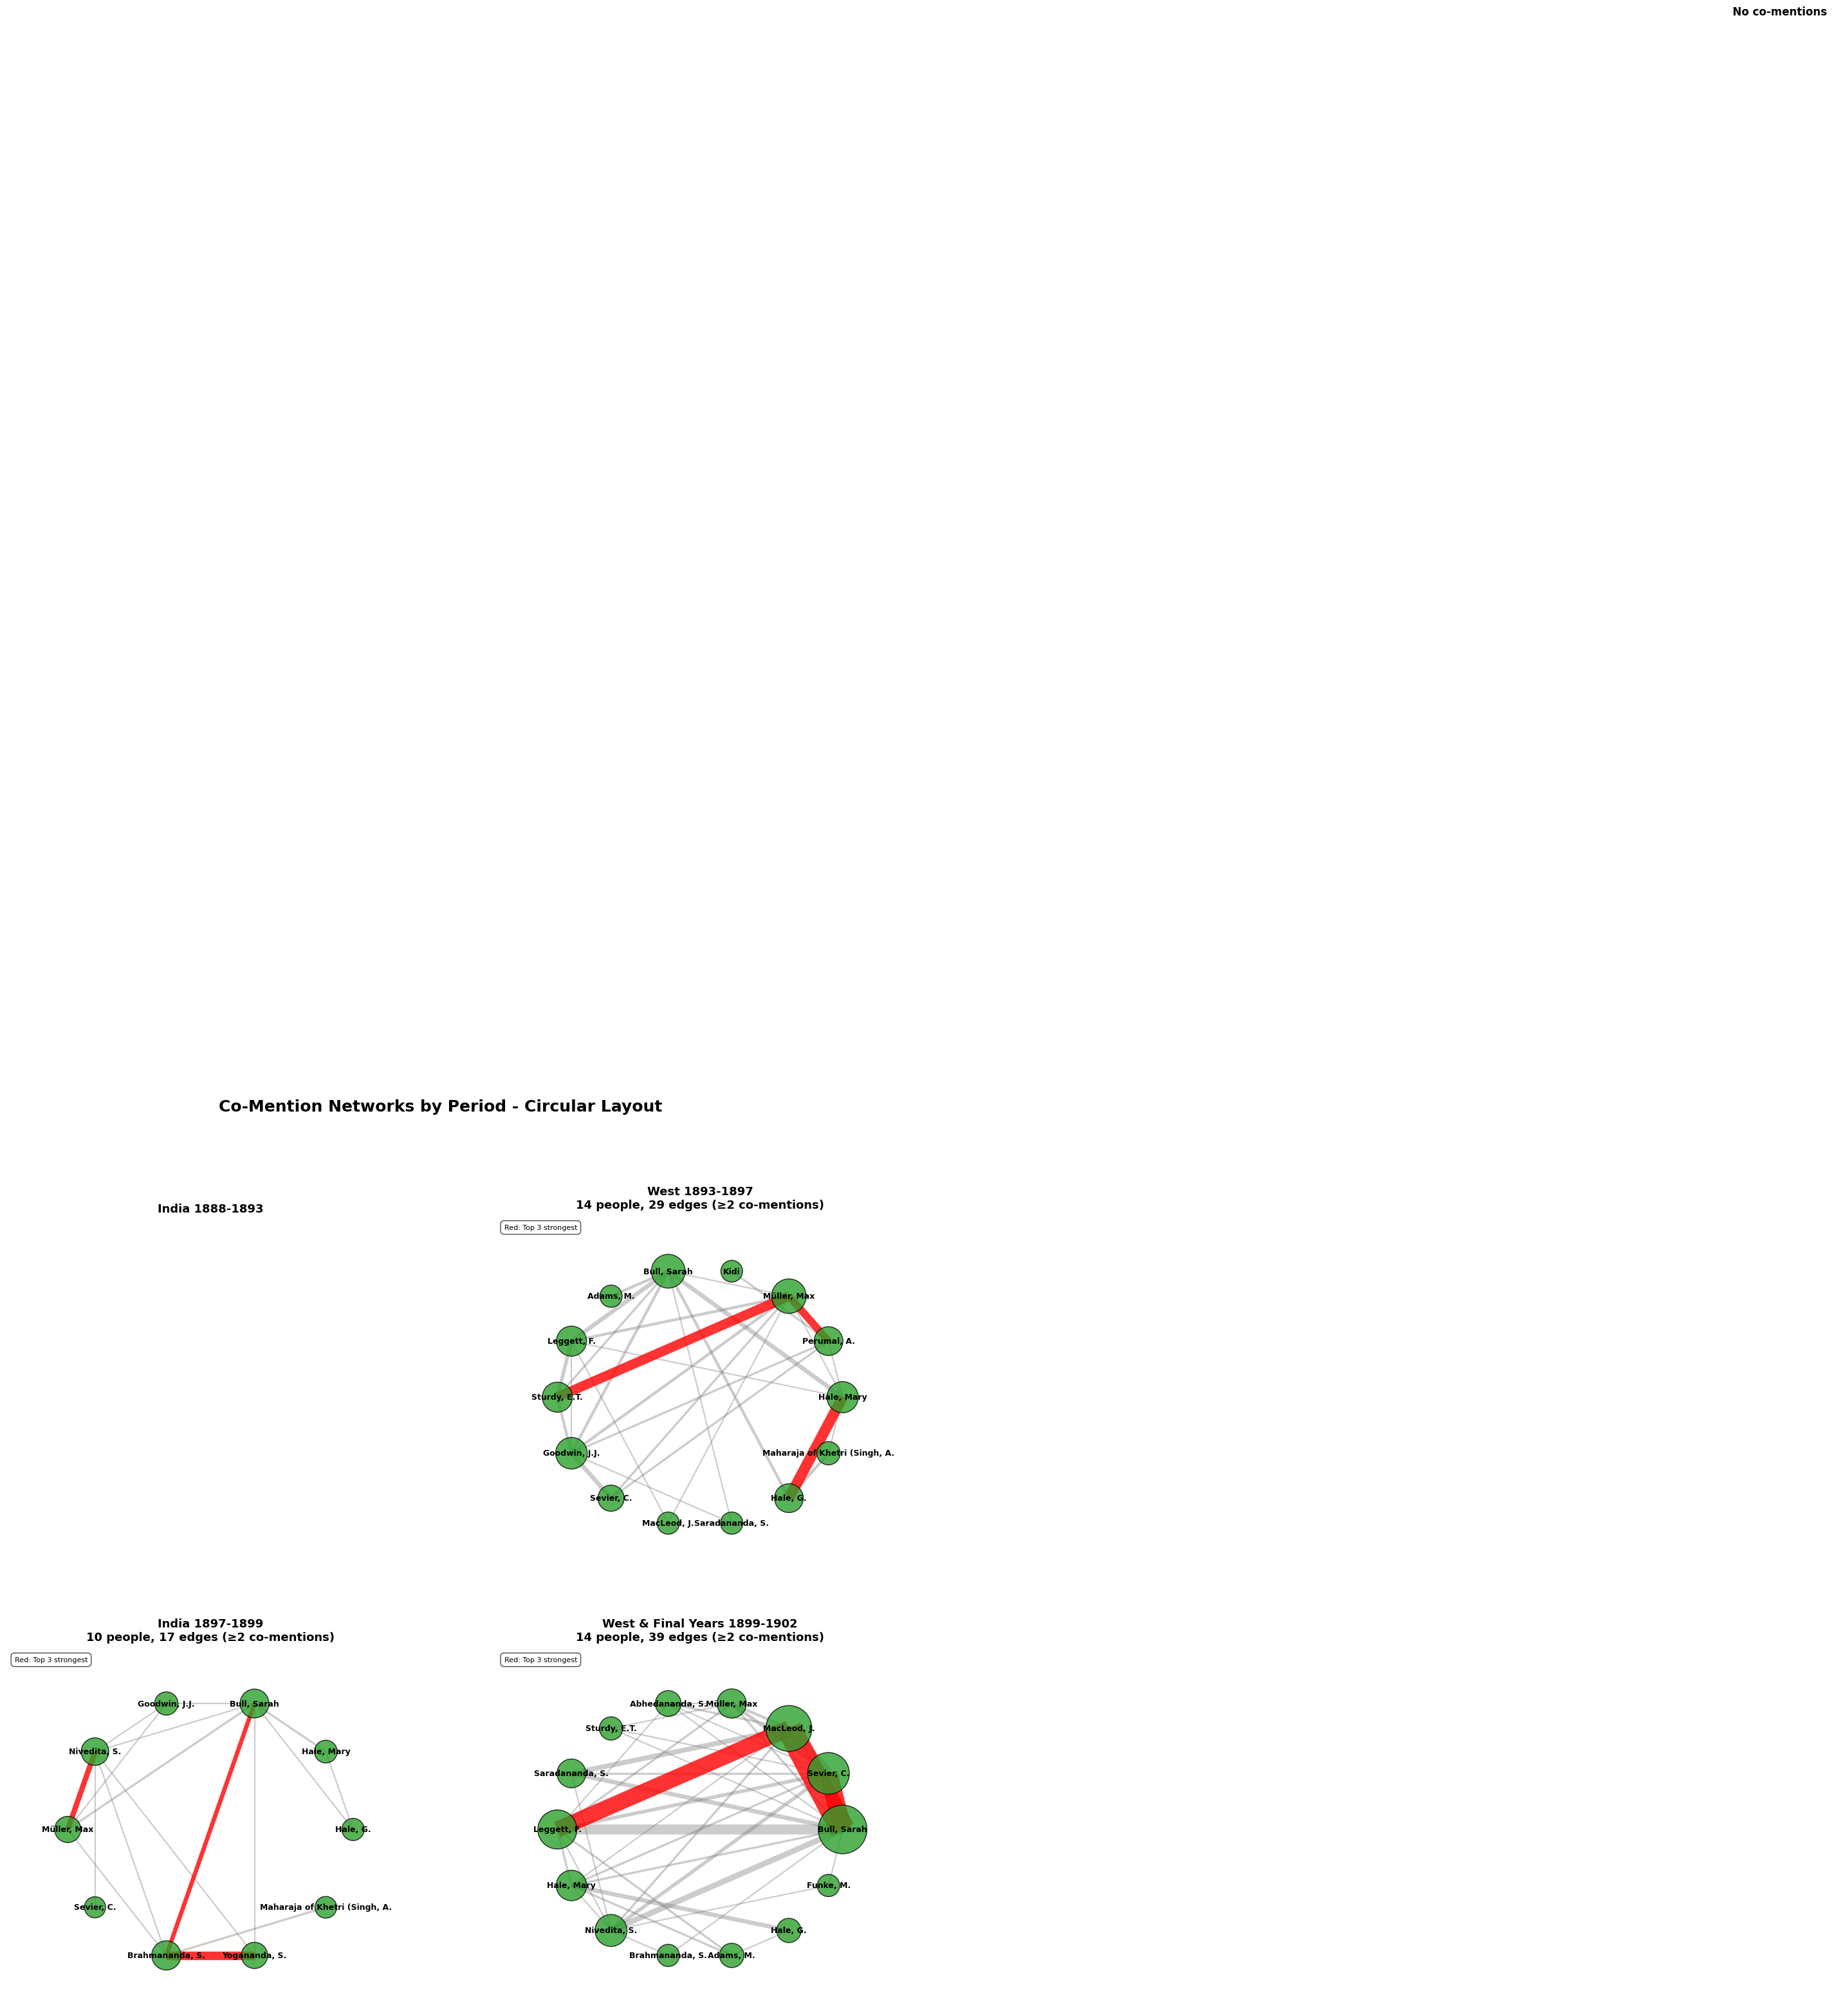


✓ Saved: comention_networks_final_circular.png

PERIOD 1 DETAILED ANALYSIS

FINAL SUMMARY
✓ Expanded nickname mapping: 117 mappings
✓ Tracked people: 115
✓ Period 1: No threshold (all co-mentions shown)
✓ Other periods: ≥2 co-mentions threshold
✓ Layout: Circular (clean, symmetric)
✓ Node borders: Thinner (linewidth=1)
✓ Node sizes: Base 500, scaling *30


In [22]:
# ============================================================================
# FINAL CO-MENTION NETWORKS - COMPLETE VERSION
# Expanded mappings + Circular layout + Period 1 special handling
# ============================================================================

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("FINAL CO-MENTION NETWORKS WITH CORRECTIONS")
print("="*80)

# ============================================================================
# STEP 1: EXPAND NICKNAME MAPPING WITH NEW DISCOVERIES
# ============================================================================
print("\n[STEP 1] Adding new nickname mappings...")

# Add new mappings to existing
nickname_mapping_final = nickname_mapping_expanded.copy()

new_mappings = {
    # Newly discovered from Period 1
    'Yogen': 'Yogananda, Swami',
    'Swami Yogananda': 'Yogananda, Swami',
    'Yogananda': 'Yogananda, Swami',

    'Balaram Babu': 'Bose, Balaram',
    'Babu Balaram Bose': 'Bose, Balaram',
    'Balaram Bose': 'Bose, Balaram',

    'Pavhari Baba': 'Pavhari Baba',
    'Pavhâri Bâbâ': 'Pavhari Baba',
    'Babaji': 'Pavhari Baba',
    'Bâbâ': 'Pavhari Baba',
}

nickname_mapping_final.update(new_mappings)

print(f"  Added {len(new_mappings)} new mappings")
print("  New people:")
for key in ['Yogen', 'Balaram Babu', 'Pavhari Baba']:
    if key in new_mappings:
        print(f"    - '{key}' → '{new_mappings[key]}'")

# Re-apply mapping to mentions
mentions_df['resolved_name'] = mentions_df['name'].replace(nickname_mapping_final)
resolved_mentions_df = mentions_df.copy()

# ============================================================================
# STEP 2: EXPAND TRACKED PEOPLE
# ============================================================================
print("\n[STEP 2] Expanding tracked people list...")

# Add new important people
important_people_expanded = {
    'Sevier, Capt. and Mrs.',
    'Müller, Max',
    'Funke, Mary Mrs.',
    'Adams, Milward Mr. and Mrs.',
    'Yogananda, Swami',
    'Bose, Balaram',
    'Pavhari Baba',
}

all_recipients = set(all_letters['Audience_clean'].dropna().unique())
people_to_track = all_recipients | important_people_expanded

print(f"  Total tracked people: {len(people_to_track)}")

# Filter mentions
recipient_mentions_df = resolved_mentions_df[
    resolved_mentions_df['resolved_name'].isin(people_to_track)
].copy()

print(f"  Mentions of tracked people: {len(recipient_mentions_df)}")

# ============================================================================
# STEP 3: BUILD CO-MENTION NETWORKS WITH PERIOD-SPECIFIC THRESHOLDS
# ============================================================================
print("\n[STEP 3] Building co-mention networks...")

comention_networks_final = {}

for period in sorted(all_letters['period'].unique()):
    if period == 'Unknown':
        continue

    # Period 1 gets NO THRESHOLD (show all co-mentions)
    # Other periods get threshold of 2
    threshold = 1 if period == 'Period1_India_1888-1893' else 2

    period_mentions = recipient_mentions_df[recipient_mentions_df['period'] == period]

    G = nx.Graph()
    comention_counts = defaultdict(int)

    for letter_id in period_mentions['letter_id'].unique():
        letter_mentions = period_mentions[period_mentions['letter_id'] == letter_id]
        mentioned_people = letter_mentions['resolved_name'].unique()

        for i, person1 in enumerate(mentioned_people):
            for person2 in mentioned_people[i+1:]:
                pair = tuple(sorted([person1, person2]))
                comention_counts[pair] += 1

    # Add edges with threshold
    for (person1, person2), weight in comention_counts.items():
        if weight >= threshold:
            G.add_edge(person1, person2, weight=weight)

    # Remove isolated nodes
    isolated_nodes = list(nx.isolates(G))
    G.remove_nodes_from(isolated_nodes)

    comention_networks_final[period] = G
    print(f"  {period}: {G.number_of_nodes()} people, {G.number_of_edges()} edges (threshold={threshold})")

# ============================================================================
# VISUALIZATION: CIRCULAR LAYOUT FOR ALL PERIODS
# ============================================================================
print("\n[STEP 4] Creating visualizations with circular layout...")

def abbreviate_name(name, max_length=14):
    if len(name) <= max_length:
        return name
    parts = name.split(',')
    if len(parts) >= 2:
        return f"{parts[0]}, {parts[1].strip()[0]}."
    return name[:max_length-3] + "..."

plt.rcParams['font.size'] = 10
plt.rcParams['figure.dpi'] = 100

period_labels = {
    'Period1_India_1888-1893': 'India 1888-1893',
    'Period2_West_1893-1897': 'West 1893-1897',
    'Period3_India_1897-1899': 'India 1897-1899',
    'Period4_West_Final_1899-1902': 'West & Final Years 1899-1902'
}

fig, axes = plt.subplots(2, 2, figsize=(18, 16))
fig.suptitle('Co-Mention Networks by Period - Circular Layout',
             fontsize=18, fontweight='bold', y=0.995)

periods = sorted([p for p in comention_networks_final.keys()])
axes_flat = axes.flatten()

for idx, period in enumerate(periods):
    ax = axes_flat[idx]
    G = comention_networks_final[period]

    if G.number_of_nodes() > 1 and G.number_of_edges() > 0:
        # Take top 15 nodes by degree (or all if fewer)
        degrees = dict(G.degree(weight='weight'))
        if len(degrees) > 15:
            top_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:15]
            top_node_names = [node for node, deg in top_nodes]
            G_sub = G.subgraph(top_node_names).copy()
        else:
            G_sub = G

        if G_sub.number_of_nodes() > 0:
            # CIRCULAR LAYOUT
            pos = nx.circular_layout(G_sub)

            # LARGER NODE SIZES
            node_sizes = [500 + degrees.get(node, 0) * 30 for node in G_sub.nodes()]

            # Get edge weights and identify top 3
            edge_weights = [(u, v, G_sub[u][v]['weight']) for u, v in G_sub.edges()]
            edge_weights_sorted = sorted(edge_weights, key=lambda x: x[2], reverse=True)
            top_3_edges = set([(u, v) for u, v, w in edge_weights_sorted[:3]])

            # Draw regular edges
            regular_edges = [(u, v) for u, v in G_sub.edges()
                            if (u, v) not in top_3_edges and (v, u) not in top_3_edges]
            regular_widths = [G_sub[u][v]['weight'] * 0.8 for u, v in regular_edges]

            if len(regular_edges) > 0:
                nx.draw_networkx_edges(G_sub, pos, ax=ax, edgelist=regular_edges,
                                     width=regular_widths, alpha=0.4, edge_color='gray')

            # Draw top 3 edges in red
            top_3_edges_list = [(u, v) for u, v in G_sub.edges()
                               if (u, v) in top_3_edges or (v, u) in top_3_edges]
            top_3_widths = [G_sub[u][v]['weight'] * 1.2 for u, v in top_3_edges_list]

            if len(top_3_edges_list) > 0:
                nx.draw_networkx_edges(G_sub, pos, ax=ax, edgelist=top_3_edges_list,
                                     width=top_3_widths, alpha=0.8, edge_color='red')

            # Draw nodes with THINNER borders
            nx.draw_networkx_nodes(G_sub, pos, ax=ax, node_size=node_sizes,
                                 node_color='#2ca02c', alpha=0.8,
                                 edgecolors='black', linewidths=1)  # Changed from 2 to 1

            # Draw labels
            labels = {node: abbreviate_name(node, 14) for node in G_sub.nodes()}
            nx.draw_networkx_labels(G_sub, pos, labels, ax=ax, font_size=9,
                                   font_weight='bold', font_color='black')

            # Title with stats
            n_total_nodes = G.number_of_nodes()
            n_total_edges = G.number_of_edges()
            threshold_text = "all co-mentions" if period == 'Period1_India_1888-1893' else "≥2 co-mentions"
            ax.set_title(f"{period_labels[period]}\n{n_total_nodes} people, {n_total_edges} edges ({threshold_text})",
                       fontsize=13, fontweight='bold', pad=10)

            # Add legend for top 3 edges
            if len(top_3_edges_list) > 0:
                legend_text = "Red: Top 3 strongest"
                ax.text(0.02, 0.98, legend_text, transform=ax.transAxes,
                       fontsize=8, verticalalignment='top',
                       bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.7))
        else:
            ax.text(0.5, 0.5, 'No co-mentions', ha='center', va='center',
                   fontsize=12, fontweight='bold')
            ax.set_title(period_labels[period], fontsize=13, fontweight='bold')
    else:
        ax.text(0.5, 0.5, 'No co-mentions', ha='center', va='center',
               fontsize=12, fontweight='bold')
        ax.set_title(period_labels[period], fontsize=13, fontweight='bold')

    ax.axis('off')
    ax.margins(0.15)

plt.tight_layout()
plt.savefig('comention_networks_final_circular.png', dpi=200, bbox_inches='tight')
plt.show()

print("\n✓ Saved: comention_networks_final_circular.png")

# ============================================================================
# PERIOD 1 SPECIFIC ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("PERIOD 1 DETAILED ANALYSIS")
print("="*80)

period1_G = comention_networks_final.get('Period1_India_1888-1893')
if period1_G and period1_G.number_of_nodes() > 0:
    print(f"\nPeriod 1 co-mention network:")
    print(f"  Nodes: {period1_G.number_of_nodes()}")
    print(f"  Edges: {period1_G.number_of_edges()}")

    # Check if Pramadadas Mitra is in the network
    if 'Mitra, Pramadadas' in period1_G.nodes():
        print(f"\n✓ Pramadadas Mitra is in the network")
        neighbors = list(period1_G.neighbors('Mitra, Pramadadas'))
        print(f"  Connected to {len(neighbors)} people:")
        for neighbor in neighbors:
            weight = period1_G['Mitra, Pramadadas'][neighbor]['weight']
            print(f"    - {neighbor}: {weight} co-mentions")
    else:
        print(f"\n✗ Pramadadas Mitra NOT in the network")
        print(f"  People in Period 1 network: {list(period1_G.nodes())}")

# ============================================================================
# SUMMARY
# ============================================================================
print("\n" + "="*80)
print("FINAL SUMMARY")
print("="*80)
print(f"✓ Expanded nickname mapping: {len(nickname_mapping_final)} mappings")
print(f"✓ Tracked people: {len(people_to_track)}")
print(f"✓ Period 1: No threshold (all co-mentions shown)")
print(f"✓ Other periods: ≥2 co-mentions threshold")
print(f"✓ Layout: Circular (clean, symmetric)")
print(f"✓ Node borders: Thinner (linewidth=1)")
print(f"✓ Node sizes: Base 500, scaling *30")
print("="*80)

# Update global variables
comention_networks = comention_networks_final
nickname_mapping = nickname_mapping_final

PERIOD 1 CO-MENTION NETWORK - PROPER EXTRACTION

[STEP 1] Extracting mentions from ALL Period 1 letters...
Total Period 1 letters: 60
  Total mentions extracted: 288
  Unique names after mapping: 157
  Mentions of tracked people: 59
  Unique tracked people: 6

  Top mentioned people in Period 1:
    - Pavhari Baba: 33 mentions
    - Akhandananda, Swami: 11 mentions
    - Abhedananda, Swami: 9 mentions
    - Bose, Balaram: 4 mentions
    - Yogananda, Swami: 1 mentions
    - Ramakrishnananda, Swami: 1 mentions

[STEP 2] Building Period 1 co-mention network...
  Network: 4 people, 6 edges

[STEP 3] Creating Period 1 co-mention network visualization...


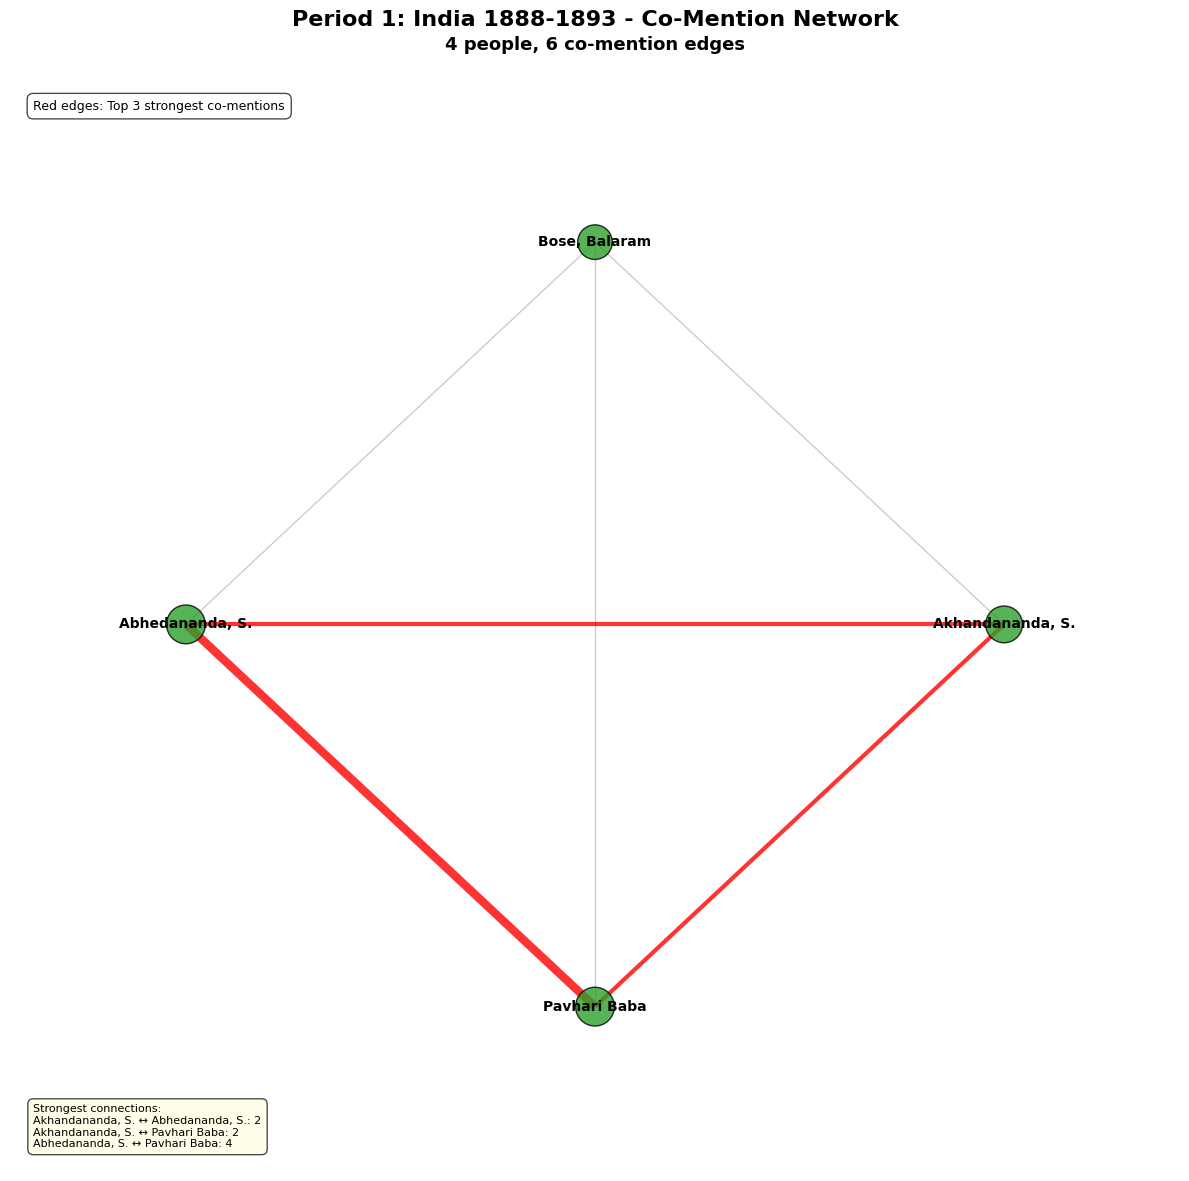


✓ Saved: period1_comention_network.png

PERIOD 1 NETWORK SUMMARY

Network Statistics:
  Nodes: 4
  Edges: 6

All connections:
  Abhedananda, Swami ↔ Pavhari Baba: 4 co-mentions
  Akhandananda, Swami ↔ Abhedananda, Swami: 2 co-mentions
  Akhandananda, Swami ↔ Pavhari Baba: 2 co-mentions
  Akhandananda, Swami ↔ Bose, Balaram: 1 co-mentions
  Bose, Balaram ↔ Abhedananda, Swami: 1 co-mentions
  Bose, Balaram ↔ Pavhari Baba: 1 co-mentions


In [23]:
# ============================================================================
# PERIOD 1 CO-MENTION NETWORK - PROPER EXTRACTION
# Extract from ALL Period 1 letters, not just focus correspondents
# ============================================================================

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("PERIOD 1 CO-MENTION NETWORK - PROPER EXTRACTION")
print("="*80)

# ============================================================================
# STEP 1: Extract mentions from ALL Period 1 letters
# ============================================================================
print("\n[STEP 1] Extracting mentions from ALL Period 1 letters...")

period1_letters = all_letters[all_letters['period'] == 'Period1_India_1888-1893']
print(f"Total Period 1 letters: {len(period1_letters)}")

# Complete nickname mapping
nickname_mapping_complete = {
    'Yogen': 'Yogananda, Swami',
    'Swami Yogananda': 'Yogananda, Swami',
    'Yogananda': 'Yogananda, Swami',

    'Balaram Babu': 'Bose, Balaram',
    'Babu Balaram Bose': 'Bose, Balaram',
    'Balaram Bose': 'Bose, Balaram',

    'Pavhari Baba': 'Pavhari Baba',
    'Pavhâri Bâbâ': 'Pavhari Baba',
    'Babaji': 'Pavhari Baba',
    'Bâbâ': 'Pavhari Baba',

    'Gangadhar': 'Akhandananda, Swami',
    'Swami Akhandananda': 'Akhandananda, Swami',
    'Akhandananda': 'Akhandananda, Swami',

    'Kali': 'Abhedananda, Swami',
    'Swami Abhedananda': 'Abhedananda, Swami',
    'Abhedananda': 'Abhedananda, Swami',
    'Kali Maharaj': 'Abhedananda, Swami',

    'Shashi': 'Ramakrishnananda, Swami',
    'Swami Ramakrishnananda': 'Ramakrishnananda, Swami',
    'Ramakrishnananda': 'Ramakrishnananda, Swami',

    'Rakhal': 'Brahmananda, Swami',
    'Swami Brahmananda': 'Brahmananda, Swami',
    'Brahmananda': 'Brahmananda, Swami',
    'Rakhal Maharaj': 'Brahmananda, Swami',
}

# Extract mentions from ALL Period 1 letters
if nlp is not None:
    period1_mentions_all = []

    for idx, row in period1_letters.iterrows():
        if pd.notna(row['body_text']) and len(str(row['body_text'])) > 10:
            try:
                text = str(row['body_text'])[:50000]
                doc = nlp(text)

                for ent in doc.ents:
                    if ent.label_ == 'PERSON':
                        name = ent.text.strip()
                        if len(name) > 2 and name.lower() not in ['sir', 'mr', 'mrs', 'miss', 'dr', 'swami', 'sister', 'the']:
                            period1_mentions_all.append({
                                'name': name,
                                'letter_id': idx,
                                'recipient': row['Audience_clean'],
                            })
            except:
                continue

    period1_mentions_df = pd.DataFrame(period1_mentions_all)
    print(f"  Total mentions extracted: {len(period1_mentions_df)}")

    # Apply nickname mapping
    period1_mentions_df['resolved_name'] = period1_mentions_df['name'].replace(nickname_mapping_complete)

    print(f"  Unique names after mapping: {period1_mentions_df['resolved_name'].nunique()}")

    # Filter to people we care about (recipients + important people)
    all_recipients = set(all_letters['Audience_clean'].dropna().unique())
    important_people = {
        'Pavhari Baba',
        'Yogananda, Swami',
        'Bose, Balaram',
        'Akhandananda, Swami',
        'Abhedananda, Swami',
        'Ramakrishnananda, Swami',
        'Brahmananda, Swami',
    }
    people_to_track_period1 = all_recipients | important_people

    period1_mentions_filtered = period1_mentions_df[
        period1_mentions_df['resolved_name'].isin(people_to_track_period1)
    ]

    print(f"  Mentions of tracked people: {len(period1_mentions_filtered)}")
    print(f"  Unique tracked people: {period1_mentions_filtered['resolved_name'].nunique()}")

    print("\n  Top mentioned people in Period 1:")
    for name, count in period1_mentions_filtered['resolved_name'].value_counts().head(10).items():
        print(f"    - {name}: {count} mentions")
else:
    print("  ⚠ spaCy not loaded")
    period1_mentions_filtered = pd.DataFrame()

# ============================================================================
# STEP 2: Build Period 1 Co-mention Network
# ============================================================================
print("\n[STEP 2] Building Period 1 co-mention network...")

G_period1 = nx.Graph()
comention_counts = defaultdict(int)

for letter_id in period1_mentions_filtered['letter_id'].unique():
    letter_mentions = period1_mentions_filtered[period1_mentions_filtered['letter_id'] == letter_id]
    mentioned_people = letter_mentions['resolved_name'].unique()

    # Create edges for all pairs
    for i, person1 in enumerate(mentioned_people):
        for person2 in mentioned_people[i+1:]:
            pair = tuple(sorted([person1, person2]))
            comention_counts[pair] += 1

# Add all edges (no threshold for Period 1)
for (person1, person2), weight in comention_counts.items():
    G_period1.add_edge(person1, person2, weight=weight)

# Remove isolated nodes
isolated = list(nx.isolates(G_period1))
G_period1.remove_nodes_from(isolated)

print(f"  Network: {G_period1.number_of_nodes()} people, {G_period1.number_of_edges()} edges")

# ============================================================================
# STEP 3: Visualize Period 1 Network
# ============================================================================
print("\n[STEP 3] Creating Period 1 co-mention network visualization...")

def abbreviate_name(name, max_length=14):
    if len(name) <= max_length:
        return name
    parts = name.split(',')
    if len(parts) >= 2:
        return f"{parts[0]}, {parts[1].strip()[0]}."
    return name[:max_length-3] + "..."

fig, ax = plt.subplots(figsize=(12, 12))
fig.suptitle('Period 1: India 1888-1893 - Co-Mention Network',
             fontsize=16, fontweight='bold')

if G_period1.number_of_nodes() > 0:
    # Circular layout
    pos = nx.circular_layout(G_period1)

    # Node sizes based on degree
    degrees = dict(G_period1.degree(weight='weight'))
    node_sizes = [500 + degrees.get(node, 0) * 40 for node in G_period1.nodes()]

    # Get top 3 edges
    edge_weights = [(u, v, G_period1[u][v]['weight']) for u, v in G_period1.edges()]
    edge_weights_sorted = sorted(edge_weights, key=lambda x: x[2], reverse=True)
    top_3_edges = set([(u, v) for u, v, w in edge_weights_sorted[:3]])

    # Draw regular edges
    regular_edges = [(u, v) for u, v in G_period1.edges()
                    if (u, v) not in top_3_edges and (v, u) not in top_3_edges]
    regular_widths = [G_period1[u][v]['weight'] * 1.0 for u, v in regular_edges]

    if len(regular_edges) > 0:
        nx.draw_networkx_edges(G_period1, pos, ax=ax, edgelist=regular_edges,
                             width=regular_widths, alpha=0.4, edge_color='gray')

    # Draw top 3 edges in RED
    top_3_edges_list = [(u, v) for u, v in G_period1.edges()
                       if (u, v) in top_3_edges or (v, u) in top_3_edges]
    top_3_widths = [G_period1[u][v]['weight'] * 1.5 for u, v in top_3_edges_list]

    if len(top_3_edges_list) > 0:
        nx.draw_networkx_edges(G_period1, pos, ax=ax, edgelist=top_3_edges_list,
                             width=top_3_widths, alpha=0.8, edge_color='red')

    # Draw GREEN nodes with THIN borders
    nx.draw_networkx_nodes(G_period1, pos, ax=ax, node_size=node_sizes,
                         node_color='#2ca02c', alpha=0.8,
                         edgecolors='black', linewidths=1)

    # Draw labels
    labels = {node: abbreviate_name(node, 16) for node in G_period1.nodes()}
    nx.draw_networkx_labels(G_period1, pos, labels, ax=ax, font_size=10,
                           font_weight='bold', font_color='black')

    # Title
    ax.set_title(f"{G_period1.number_of_nodes()} people, {G_period1.number_of_edges()} co-mention edges",
               fontsize=13, fontweight='bold', pad=20)

    # Legend
    legend_text = "Red edges: Top 3 strongest co-mentions"
    ax.text(0.02, 0.98, legend_text, transform=ax.transAxes,
           fontsize=9, verticalalignment='top',
           bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.7))

    # Show top edges
    if len(top_3_edges_list) > 0:
        info_text = "Strongest connections:\n"
        for u, v in top_3_edges_list:
            weight = G_period1[u][v]['weight']
            info_text += f"{abbreviate_name(u, 12)} ↔ {abbreviate_name(v, 12)}: {weight}\n"

        ax.text(0.02, 0.02, info_text.strip(), transform=ax.transAxes,
               fontsize=8, verticalalignment='bottom',
               bbox=dict(boxstyle='round,pad=0.5', facecolor='lightyellow', alpha=0.7))
else:
    ax.text(0.5, 0.5, 'No co-mentions found', ha='center', va='center',
           fontsize=14, fontweight='bold')

ax.axis('off')
ax.margins(0.15)

plt.tight_layout()
plt.savefig('period1_comention_network.png', dpi=200, bbox_inches='tight')
plt.show()

print("\n✓ Saved: period1_comention_network.png")

# ============================================================================
# SUMMARY
# ============================================================================
print("\n" + "="*80)
print("PERIOD 1 NETWORK SUMMARY")
print("="*80)

if G_period1.number_of_nodes() > 0:
    print(f"\nNetwork Statistics:")
    print(f"  Nodes: {G_period1.number_of_nodes()}")
    print(f"  Edges: {G_period1.number_of_edges()}")

    print(f"\nAll connections:")
    for u, v in sorted(G_period1.edges(), key=lambda x: G_period1[x[0]][x[1]]['weight'], reverse=True):
        weight = G_period1[u][v]['weight']
        print(f"  {u} ↔ {v}: {weight} co-mentions")
else:
    print("\n⚠ No co-mention network could be built for Period 1")

print("="*80)